<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    German Credit dataset
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données de clients bancaires
<br/>

---

In [1]:
!pip install imblearn
!pip install --upgrade pandas

In [2]:
from datetime import datetime
from pathlib import Path
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [3]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

## Chargement des données

In [4]:
Data = Path("data.csv")

In [5]:
Dataset = pd.read_csv(Data)
# Supprimer les guillemets dans les noms de colonnes
new_columns = [col.replace("'", "") for col in Dataset.columns]

# Renommer les colonnes existantes avec les nouveaux noms de colonnes sans guillemets
Dataset = Dataset.rename(columns=dict(zip(Dataset.columns, new_columns)))
Dataset = Dataset.set_index('id')

# Définir la première colonne comme index
#Dataset = Dataset.set_index("id")

# Afficher le dataframe
display(Dataset)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
id,,,,,,,,,,,,,,,,,,,,,
1,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
2,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
3,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
4,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
5,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,good
997,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,good
998,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,...,car,38,none,own,1,skilled,1,none,yes,good


## Exploration préliminaire des données

### Analyse descriptive

In [6]:
# Afficher toutes les colonnes du DataFrame
pd.set_option("display.max_columns", None)
# Afficher les 3 premières lignes du dataframe
Dataset.head(3)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
id,,,,,,,,,,,,,,,,,,,,,
1,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,good
2,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes,bad
3,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes,good


In [7]:
# Afficher les 3 dernières lignes du dataframe
Dataset.tail(3)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
id,,,,,,,,,,,,,,,,,,,,,
998,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,4,car,38,none,own,1,skilled,1,none,yes,good
999,<0,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,4,no known property,23,none,for free,1,skilled,1,yes,yes,bad
1000,0<=X<200,45,critical/other existing credit,used car,4576,100<=X<500,unemployed,3,male single,none,4,car,27,none,own,1,skilled,1,none,yes,good


In [8]:
# Afficher les infos du dataframe
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  existing_

In [9]:
# Quelques satistiques descriptives
Dataset.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1e+03,1e+03,1e+03,1e+03,1e+03,1e+03,1e+03
mean,20.9,3.27e+03,2.97,2.85,35.5,1.41,1.16
std,12.1,2.82e+03,1.12,1.1,11.4,0.578,0.362
min,4,250,1,1,19,1,1
25%,12,1.37e+03,2,2,27,1,1
50%,18,2.32e+03,3,3,33,1,1
75%,24,3.97e+03,4,4,42,2,1
max,72,1.84e+04,4,4,75,4,2


### Visualisation graphique des données

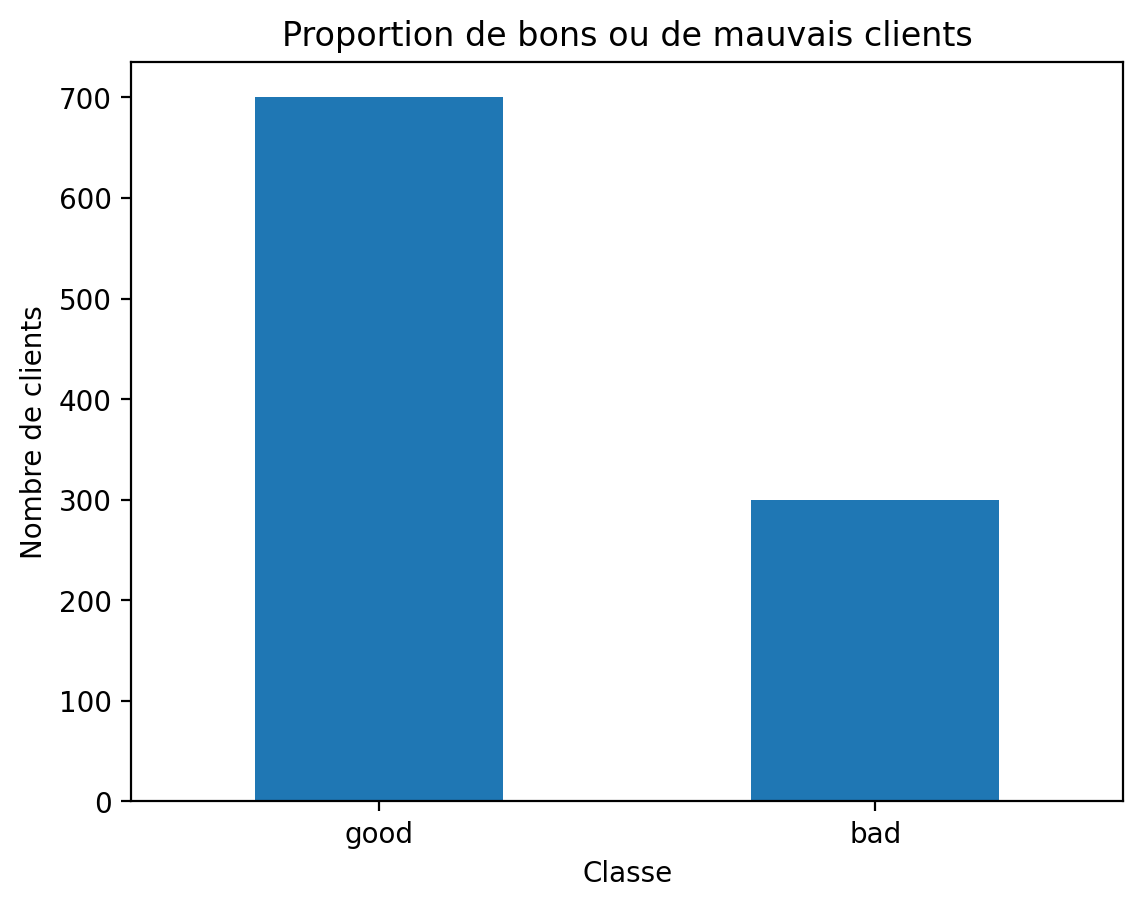

In [10]:
# Histogramme sur la proportion de bons ou de mauvais clients

# Compter le nombre de clients bons ou mauvais
x_type_cnts = Dataset['class'].value_counts()

# Tracer un histogramme
x_type_cnts.plot(kind='bar', rot=0)

# Ajouter des étiquettes d'axe et un titre
plt.xlabel("Classe")
plt.ylabel("Nombre de clients")
plt.title("Proportion de bons ou de mauvais clients")

# Afficher le graphique
plt.show()

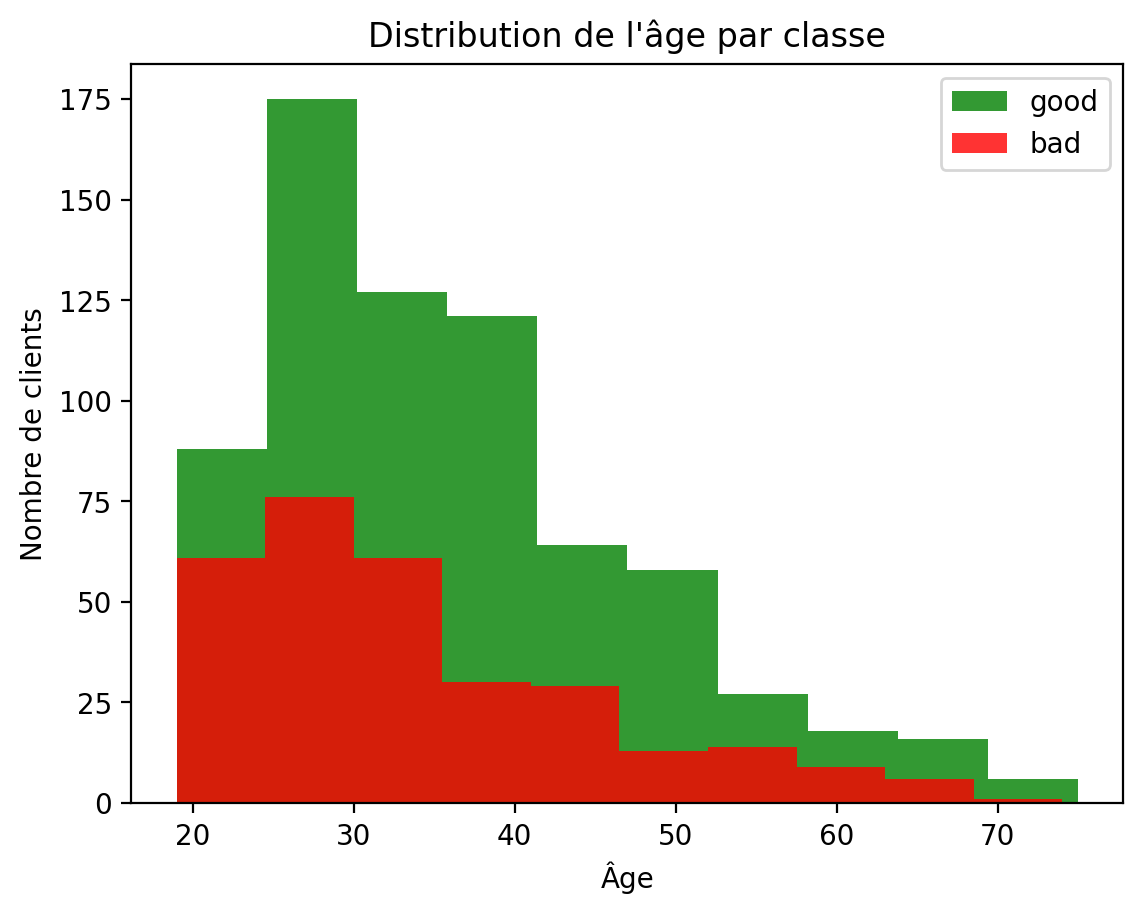

In [11]:
# Histogramme pour voir la proportion de clien par age

# Définir l'ordre des groupes
class_order = ['good', 'bad']

# Définir les couleurs pour chaque groupe
colors = ['green', 'red']

# Tracer un histogramme de l'âge pour chaque classe
for i, cls in enumerate(class_order):
    cls_data = Dataset.groupby('class').get_group(cls)['age']
    cls_data.hist(alpha=0.8, color=colors[i], label=cls)

# Ajouter une légende
plt.legend(class_order)

# Ajouter des étiquettes d'axe et un titre
plt.xlabel("Âge")
plt.ylabel("Nombre de clients")
plt.title("Distribution de l'âge par classe")
plt.grid(False)

# Afficher le graphique
plt.show()

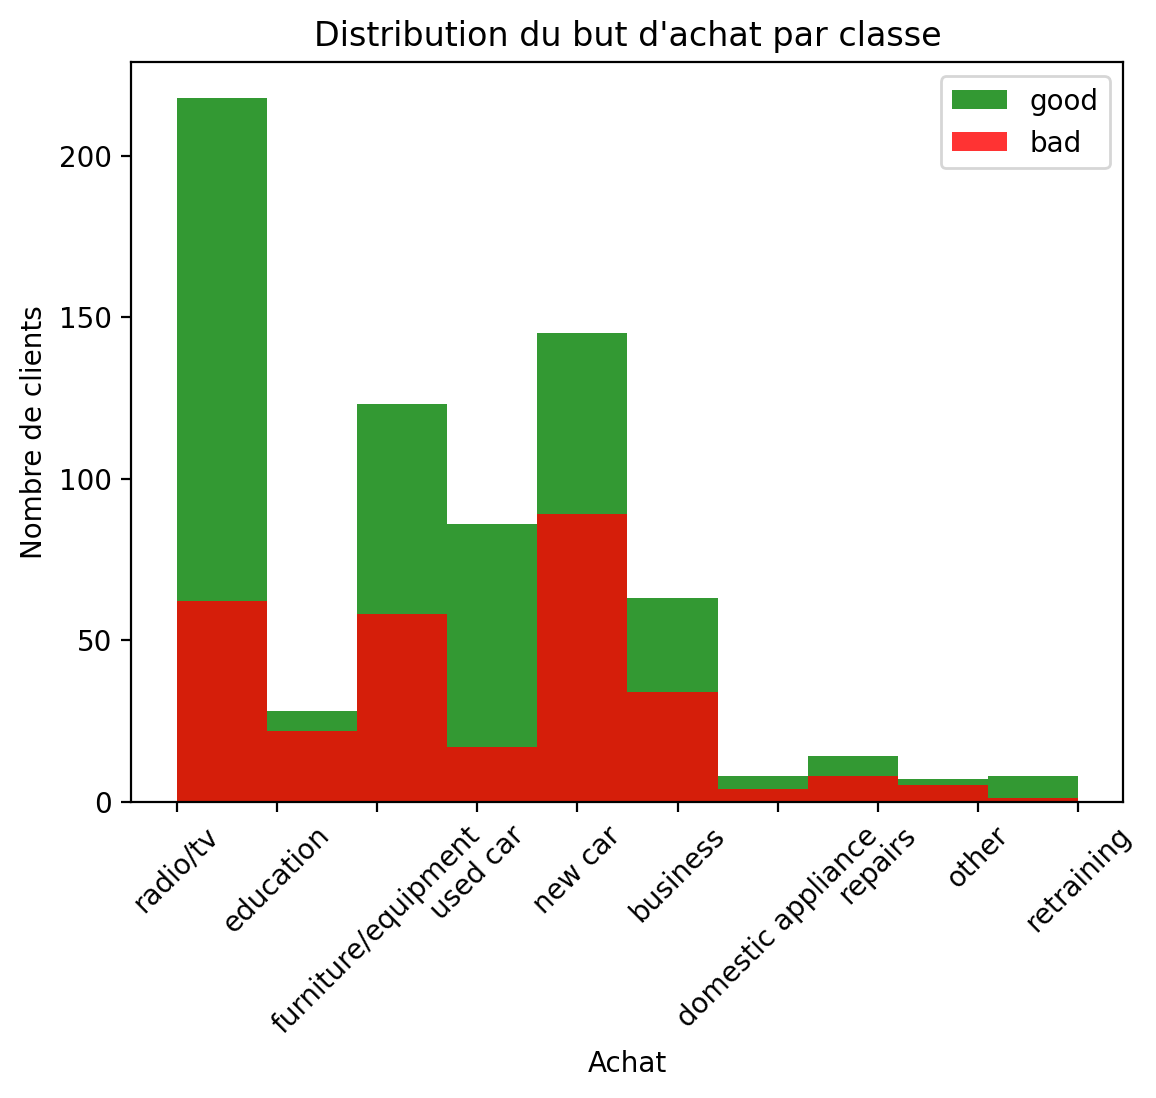

In [12]:
# Histogramme pour voir pourquoi le crédit à été demandé (purpose)

# Tracer un histogramme pour chaque classe
for i, cls in enumerate(class_order):
    cls_data = Dataset.groupby('class').get_group(cls)['purpose']
    cls_data.hist(alpha=0.8, color=colors[i], label=cls)

# Ajouter une légende
plt.legend(class_order)

# Ajouter des étiquettes d'axe et un titre
plt.xlabel("Achat")
plt.ylabel("Nombre de clients")
plt.title("Distribution du but d'achat par classe")
plt.grid(False)
plt.xticks(rotation=45)


# Afficher le graphique
plt.show()

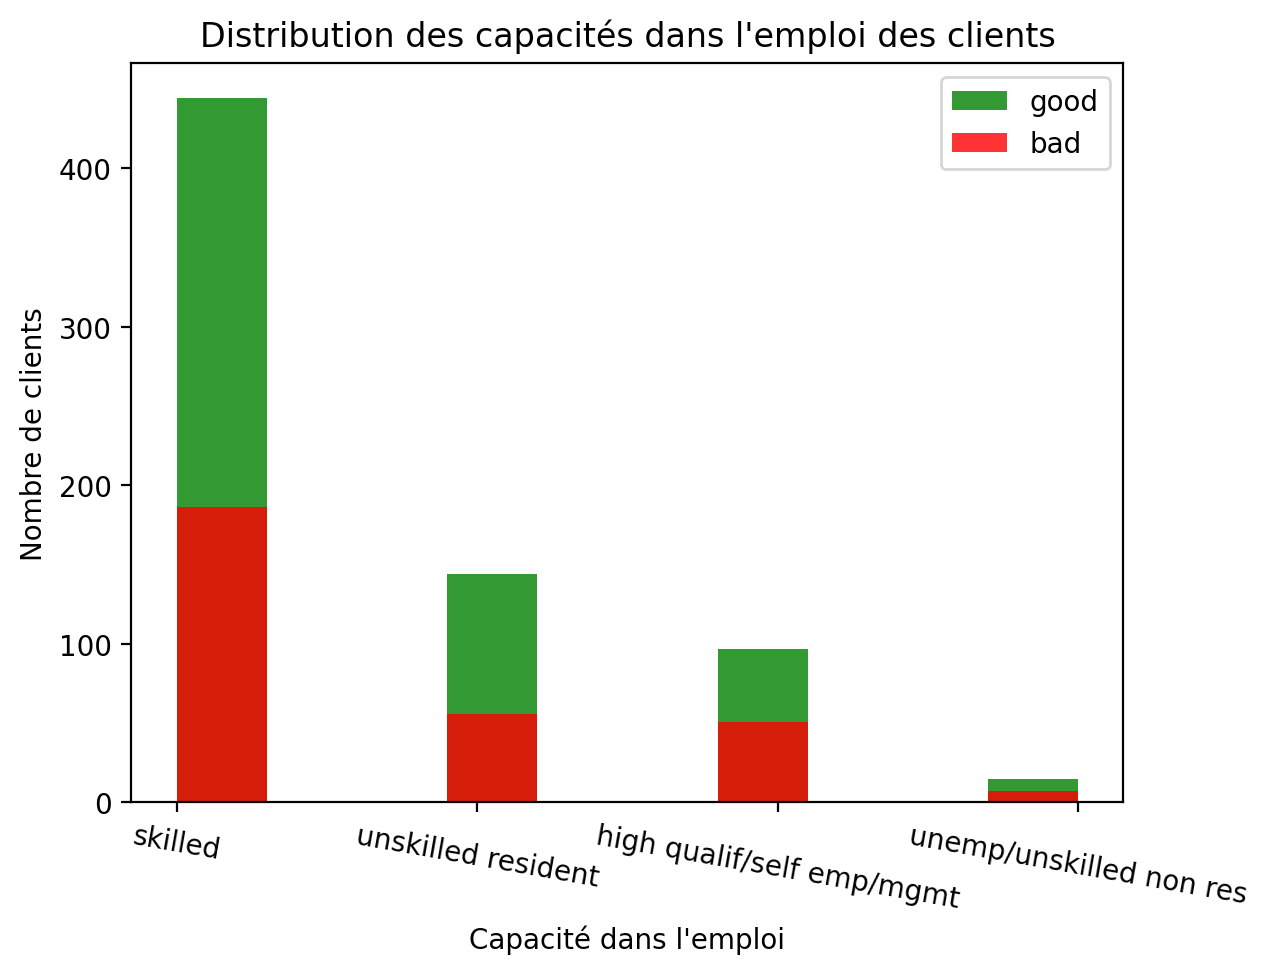

In [13]:
# Histogramme pour la proportion de bon ou de mauvais par rapport à leur employabilité

# Tracer un histogramme pour chaque classe
for i, cls in enumerate(class_order):
    cls_data = Dataset.groupby('class').get_group(cls)['job']
    cls_data.hist(alpha=0.8, color=colors[i], label=cls)

# Ajouter une légende
plt.legend(class_order)

# Ajouter des étiquettes d'axe et un titre
plt.xlabel("Capacité dans l'emploi")
plt.ylabel("Nombre de clients")
plt.title("Distribution des capacités dans l'emploi des clients")
plt.grid(False)
plt.xticks(rotation=-10)


# Afficher le graphique
plt.show()

### Corrélations

In [14]:
corrM = Dataset.corr(numeric_only = True)
corrM.style.background_gradient(cmap='coolwarm').format(precision=4)

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
duration,1.0000,0.6250,0.0747,0.0341,-0.0361,-0.0113,-0.0238
credit_amount,0.6250,1.0000,-0.2713,0.0289,0.0327,0.0208,0.0171
installment_commitment,0.0747,-0.2713,1.0000,0.0493,0.0583,0.0217,-0.0712
residence_since,0.0341,0.0289,0.0493,1.0000,0.2664,0.0896,0.0426
age,-0.0361,0.0327,0.0583,0.2664,1.0000,0.1493,0.1182
existing_credits,-0.0113,0.0208,0.0217,0.0896,0.1493,1.0000,0.1097
num_dependents,-0.0238,0.0171,-0.0712,0.0426,0.1182,0.1097,1.0000


Text(0.5, 1.0, 'Coefficient de correlation par rapport à la Classe')

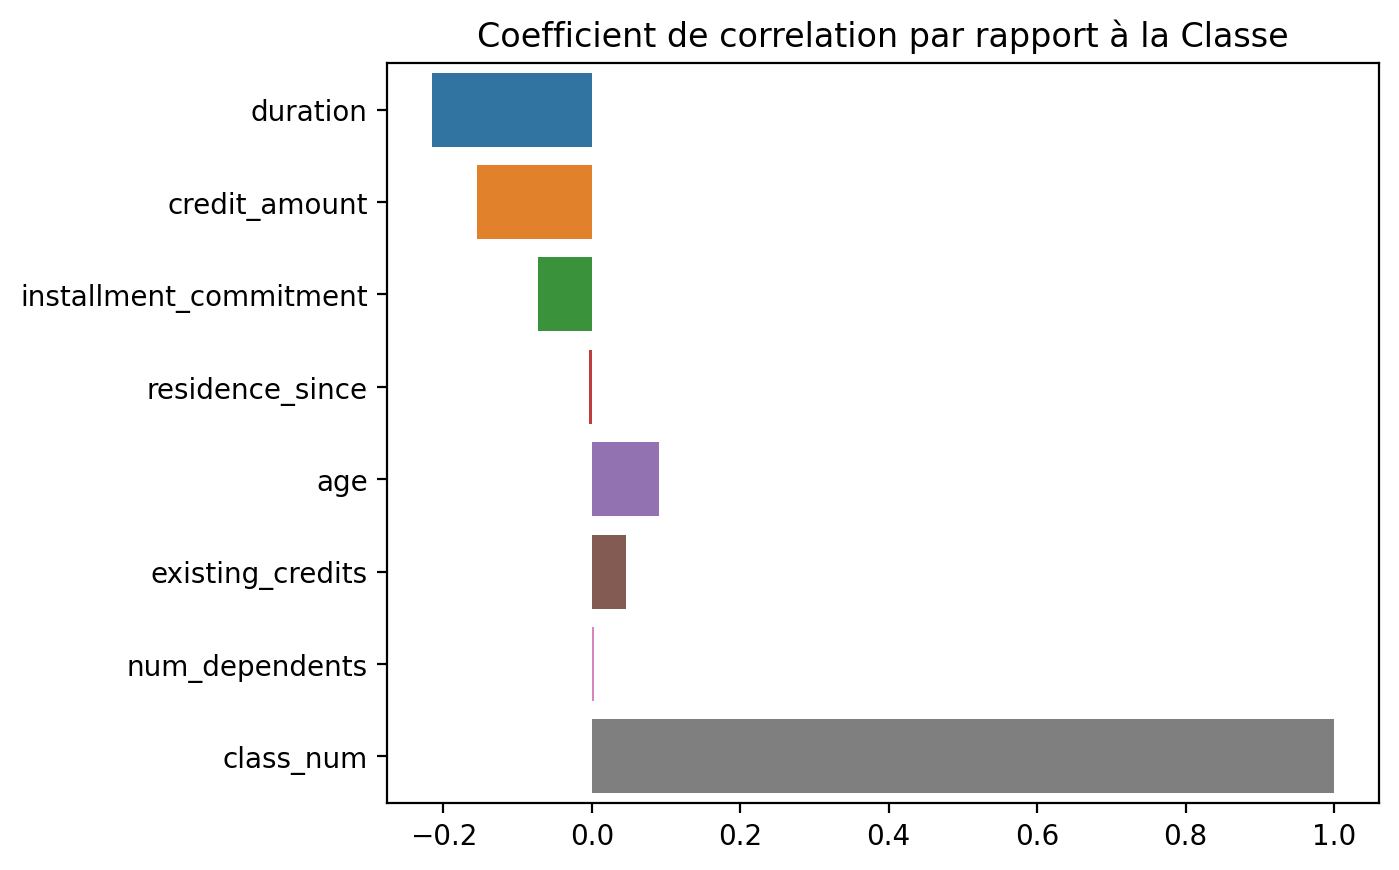

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Dataset['class_num'] = le.fit_transform(Dataset['class'])

correlations = Dataset.corrwith(Dataset['class_num'], numeric_only = True)

sns.barplot(x=correlations.values, y=correlations.index, orient='h')
plt.title("Coefficient de correlation par rapport à la Classe")

## Nettoyage des données

#### Enlever les NaN

In [16]:
# Vérifier s'il ya des NaN dans nos données
print("Il y a des NaN : " , Dataset.isnull().values.any())

Il y a des NaN :  False


#### One-Hot Encoding

In [17]:
Dataset['class'] = Dataset['class'].replace({'good': 1, 'bad': 0})
# Sélectionner toutes les caractéristiques sauf 'class'
features = Dataset.drop('class', axis=1).columns.tolist()

# Encoder les caractéristiques non numériques avec get_dummies()
Dataset_encoded = pd.get_dummies(Dataset[features])

# Ajouter la colonne 'class' au dataframe encodé
Dataset_encoded['class'] = Dataset['class']

# Afficher le dataframe encodé
display(Dataset_encoded)

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class_num,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,checking_status_no checking,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,purpose_business,purpose_domestic appliance,purpose_education,purpose_furniture/equipment,purpose_new car,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining,purpose_used car,savings_status_100<=X<500,savings_status_500<=X<1000,savings_status_<100,savings_status_>=1000,savings_status_no known savings,employment_1<=X<4,employment_4<=X<7,employment_<1,employment_>=7,employment_unemployed,personal_status_female div/dep/mar,personal_status_male div/sep,personal_status_male mar/wid,personal_status_male single,other_parties_co applicant,other_parties_guarantor,other_parties_none,property_magnitude_car,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,other_payment_plans_bank,other_payment_plans_none,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes,class
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,6,1169,4,4,67,2,1,1,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,True,False,True,1
2,48,5951,2,2,22,1,1,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,0
3,12,2096,2,3,49,1,2,1,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,1
4,42,7882,2,4,45,1,2,1,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True,1
5,24,4870,3,4,53,2,2,0,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,12,1736,3,4,31,1,1,1,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,1
997,30,3857,4,4,40,1,1,1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False

In [18]:
new_corrM = Dataset_encoded.corr(numeric_only = True)
new_corrM.style.background_gradient(cmap='coolwarm').format(precision=4)

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class_num,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,checking_status_no checking,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,purpose_business,purpose_domestic appliance,purpose_education,purpose_furniture/equipment,purpose_new car,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining,purpose_used car,savings_status_100<=X<500,savings_status_500<=X<1000,savings_status_<100,savings_status_>=1000,savings_status_no known savings,employment_1<=X<4,employment_4<=X<7,employment_<1,employment_>=7,employment_unemployed,personal_status_female div/dep/mar,personal_status_male div/sep,personal_status_male mar/wid,personal_status_male single,other_parties_co applicant,other_parties_guarantor,other_parties_none,property_magnitude_car,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,other_payment_plans_bank,other_payment_plans_none,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes,class
duration,1.0000,0.6250,0.0747,0.0341,-0.0361,-0.0113,-0.0238,-0.2149,0.0895,0.0222,-0.0765,-0.0635,0.0337,-0.0756,0.1369,-0.0698,0.1181,0.1641,-0.0372,0.0037,-0.0628,-0.1100,0.1045,-0.0443,-0.0225,-0.0722,0.1449,0.0516,-0.0403,-0.0472,-0.0483,0.0712,-0.0319,0.0796,-0.0568,0.0175,-0.0052,-0.0814,0.0064,-0.0844,0.1219,0.0297,-0.0396,0.0100,0.1195,-0.0567,0.2128,-0.2426,0.0359,-0.0676,0.0657,0.1891,-0.0752,-0.0644,0.1475,0.0550,-0.0440,-0.1812,-0.1647,0.1647,-0.1382,0.1382,-0.2149
credit_amount,0.6250,1.0000,-0.2713,0.0289,0.0327,0.0208,0.0171,-0.1547,0.1196,-0.0209,-0.1005,-0.0395,0.0059,-0.0418,0.1136,-0.0867,0.1472,0.1030,-0.0693,-0.0074,-0.0340,-0.0408,0.1929,-0.1732,-0.0289,-0.0698,0.2521,0.0135,-0.0643,-0.0364,-0.0555,0.1065,-0.0371,0.0538,-0.0515,-0.0096,0.0862,-0.0935,0.0336,-0.1383,0.1525,0.0791,-0.0652,-0.0041,0.0757,-0.0326,0.2489,-0.2483,0.0395,-0.0483,0.0243,0.2016,-0.1175,-0.0246,0.3197,-0.0926,-0.0280,-0.1618,-0.2770,0.2770,-0.0501,0.0501,-0.1547
installment_commitment,0.0747,-0.2713,1.0000,0.0493,0.0583,0.0217,-0.0712,-0.0724,-0.0519,0.0469,-0.0416,0.0250,0.0303,0.0411,-0.0146,-0.0209,-0.0544,-0.0253,0.0191,0.0425,-0.0630,-0.0458,-0.0302,0.1386,0.0402,0.0402,-0.0948,-0.0154,-0.0232,-0.0086,0.0347,0.0184,-0.0696,-0.0007,-0.0340,0.1334,-0.0494,-0.0863,-0.0970,0.0077,0.1182,-0.0130,-0.0064,0.0138,0.0170,-0.0206,0.0450,-0.0346,-0.0161,-0.0161,0.0561,0.0401,0.0499,-0.0914,0.0428,0.0426,-0.0878,-0.0572,-0.0144,0.0144,-0.0900,0.0900,-0.0724
residence_since,0.0341,0.0289,0.0493,1.0000,0.2664,0.0896,0.0426,-0.0030,-0.0558,0.0883,-0.0643,0.0020,0.0277,0.0885,-0.0204,-0.0815,0.0009,-0.0489,-0.0178,0.0406,-0.0069,0.0198,0.0405,-0.0900,0.0273,0.0134,0.1073,0.0178,0.0327,-0.0899,-0.0024,0.0806,-0.1407,-0.0312,-0.1642,0.3028,0.0361,0.0138,-0.0385,-0.1027,0.0636,0.0016,-0.0283,0.0206,-0.0415,-0.0237,0.1880,-0.0852,0.0145,0.0167,-0.0545,0.2270,-0.2975,0.1673,0.0050,-0.0007,-0.0345,0.0091,-0.0954,0.0954,-0.0541,0.0541,-0.0030
age,-0.0361,0.0327,0.0583,0.2664,1.0000,0.1493,0.1182,0.0911,-0.0781,-0.0112,0.0375,0.0624,0.0144,0.1637,0.0161,-0.1558,-0.0224,-0.0018,-0.0126,0.0685,-0.1277,0.0750,0.0424,-0.0464,0.0396,-0.0074,0.0509,-0.0753,0.0310,-0.0441,0.0320,0.0778,-0.1550,-0.0835,-0.2100,0.3625,0.1106,-0.1617,0.0624,-0.1455,0.2074,-0.0184,-0.0239,0.0308,-0.1435,-0.0287,0.2064,0.0115,0.0466,-0.0354,-0.0111,0.2531,0.0066,-0.2126,0.1276,-0.1483,0.0600,0.0437,-0.1453,0.1453,-0.0062,0.0062,0.0911
existing_credits,-0.0113,0.0208,0.0217,0.0896,0.1493,1.0000,0.1097,0.0457,-0.0527,-0.0292,-0.0402,0.0944,-0.0958,0.5014,0.1417,-0.5404,0.1124,0.0850,-0.0618,-0.0107,-0.0705,0.0358,0.0178,-0.0

<Axes: title={'center': 'Coefficient de correlation par rapport à la Classe'}>

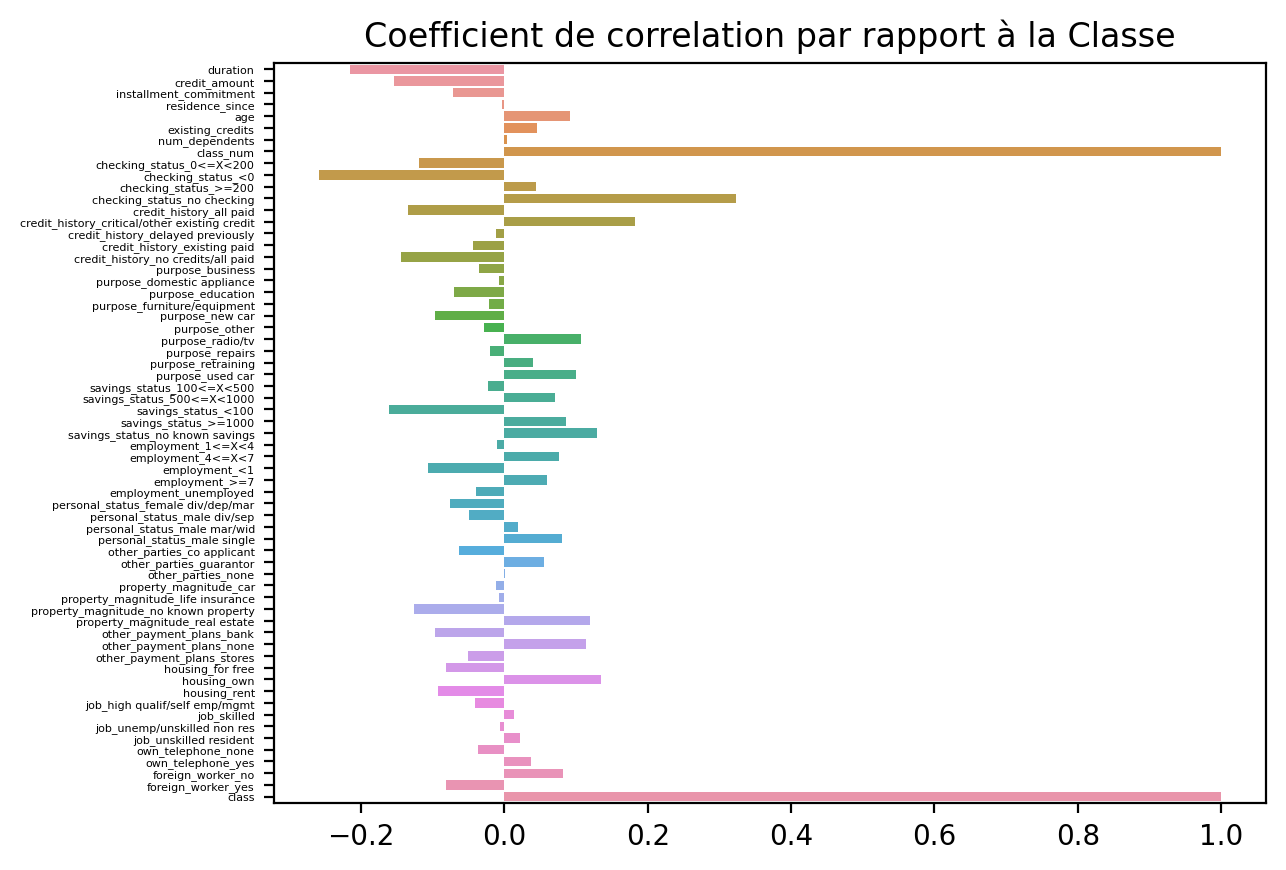

In [19]:
new_correlations_good = Dataset_encoded.corrwith(Dataset_encoded['class'], numeric_only = True)
ax = sns.barplot(x=new_correlations_good.values, y=new_correlations_good.index, orient='h')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=4)
plt.title("Coefficient de correlation par rapport à la Classe")
ax

## Séparation des données en train-test-validation :

Diviser les données en trois ensembles distincts: l'ensemble de formation, l'ensemble de validation et l'ensemble de test.

La première ligne divise les données initiales en deux parties: un ensemble de test qui représente 20% des données initiales, et un ensemble de formation et de validation combinées qui représente les 80% restants des données initiales.

La deuxième ligne divise ensuite l'ensemble de formation et de validation en deux parties distinctes: l'ensemble de formation, qui sera utilisé pour entraîner le modèle, et l'ensemble de validation, qui sera utilisé pour régler les hyperparamètres du modèle. De cette façon, nous pouvons entraîner le modèle sur l'ensemble de formation, l'ajuster sur l'ensemble de validation et finalement évaluer sa performance sur l'ensemble de test.

In [20]:
X = Dataset_encoded.drop("class", axis=1) # Les variables explicatives sont toutes les colonnes sauf "class"
y = Dataset_encoded["class"] # La variable à prédire est la colonne "class"

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

#### Normalisation :

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## PCA :

In [23]:
import sklearn
pca = sklearn.decomposition.PCA(n_components = 15)
# Appliquer la PCA sur les données d'entraînement standardisées
X_train_pca = pca.fit_transform(X_train_scaled)

# Appliquer la même transformation de PCA sur les données de test standardisées
X_test_pca = pca.transform(X_test_scaled)

In [24]:
information_gain_ratio = pca.explained_variance_ratio_
print(information_gain_ratio)

[0.07  0.052 0.046 0.042 0.037 0.034 0.032 0.031 0.03  0.03  0.025 0.025
 0.024 0.023 0.023]


In [25]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance_ratio >= 0.52) + 1
print(f"Number of components to explain 52% variance: {n_components}")

Number of components to explain 52% variance: 15


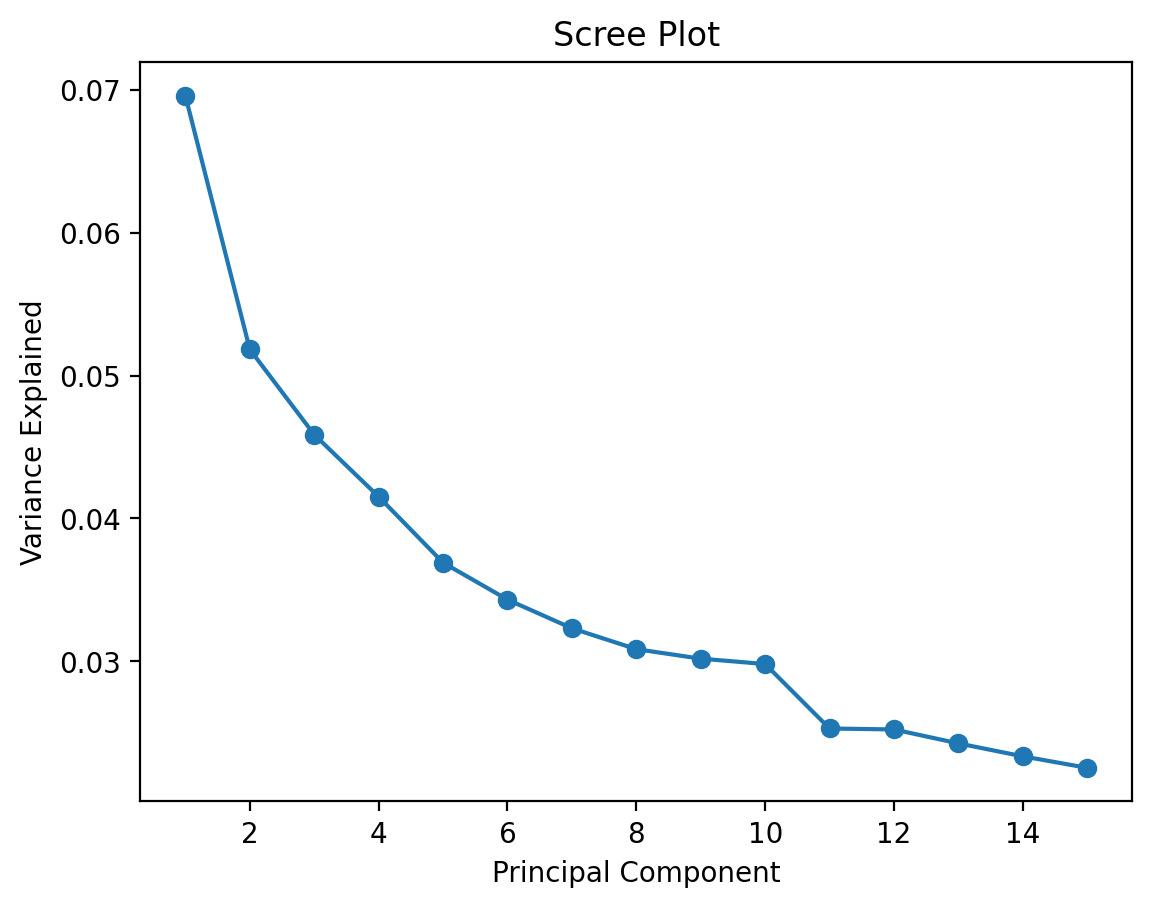

In [26]:
pc2 = np.arange(pca.n_components_) + 1

plt.plot(pc2, pca.explained_variance_ratio_, 'o-')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.show()

In [27]:
print(sum(information_gain_ratio))

0.5237160872431906


In [28]:
from matplotlib.colors import ListedColormap
def VisualizingDataset(X_, Y_):
    X1 = X_[:, 0]
    X2 = X_[:, 1]
    for i, label in enumerate(np.unique(Y_)):
        plt.scatter(X1[Y_ == label], X2[Y_ == label],
        color = ListedColormap(("green", "red"))(i),
        label = label)
    plt.legend()

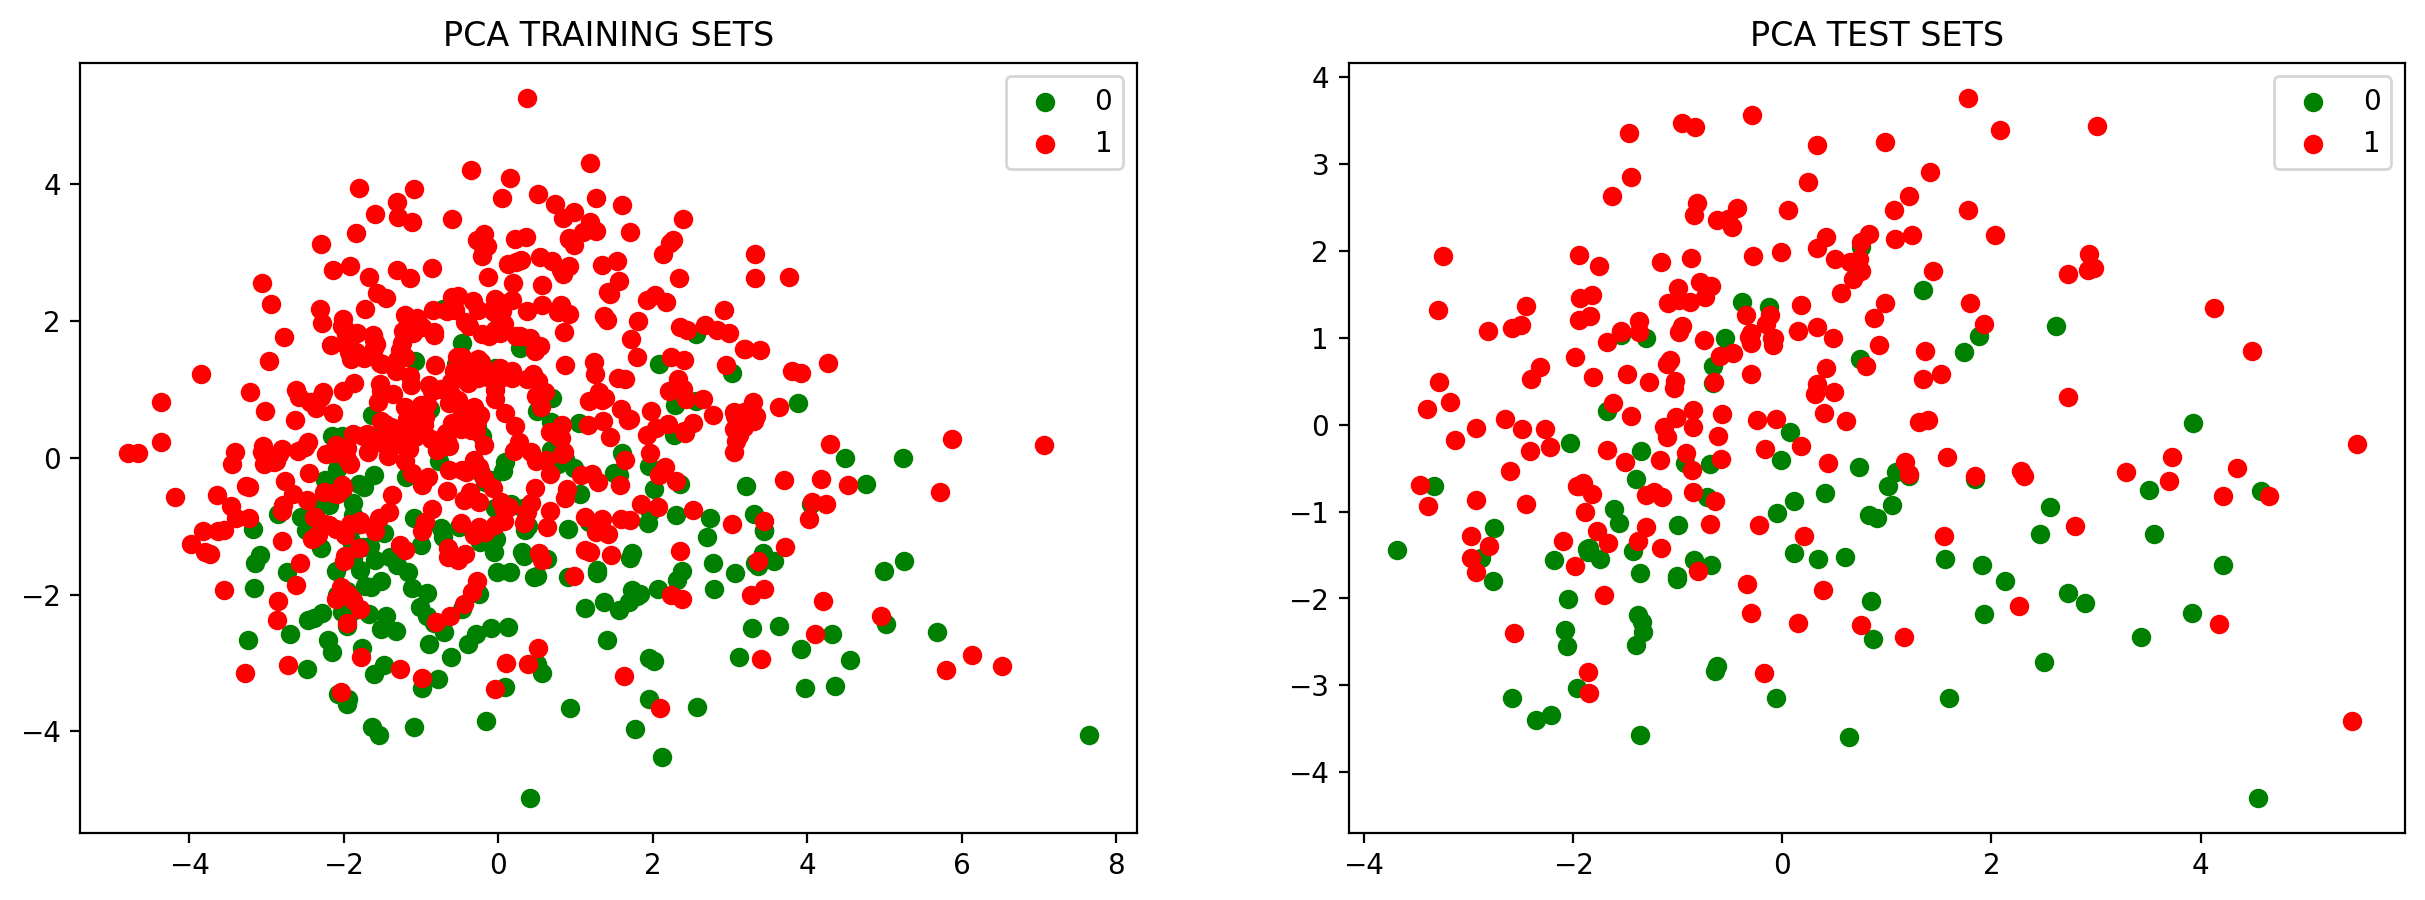

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("PCA TRAINING SETS")
VisualizingDataset(X_train_pca, Y_train)
plt.subplot(1,2,2)
plt.title("PCA TEST SETS")
VisualizingDataset(X_test_pca, Y_test)
plt.show()

En utilisant une décomposition PCA en deux composantes principales, nous avons tracé un graphique de dispersion où les points verts représentent les personnes jugées bonnes pour l'obtention d'un crédit et les points rouges représentent les personnes jugées mauvaises. Toutefois, il est observé que les nuages de points se chevauchent considérablement, ce qui suggère une difficulté à discriminer les deux catégories de personnes.

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Créer un objet SVM
svm = SVC(kernel='linear')

# Entraîner l'objet SVM
svm.fit(X_train_pca, Y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = svm.predict(X_test_pca)

# Évaluer les performances de l'objet SVM
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)
print (" ")
print(metrics.classification_report(Y_test, y_pred))

Accuracy: 0.84
 
              precision    recall  f1-score   support

           0       0.75      0.70      0.73        91
           1       0.87      0.90      0.89       209

    accuracy                           0.84       300
   macro avg       0.81      0.80      0.81       300
weighted avg       0.84      0.84      0.84       300



In [31]:
CV = 10
SCORINGS = "balanced_accuracy"
pca_CV = decomposition.PCA(n_components=15)
model_CV = SVC(kernel='linear')

pipe = pipeline.Pipeline(steps=[('scaler', StandardScaler()),("pca", pca_CV), ("model", model_CV)])

scores = model_selection.cross_val_score(pipe, X, y, cv=CV, scoring=SCORINGS)

with np.printoptions(precision=8):
    print(scores)

print(f"\n{SCORINGS}: {scores.mean():.8f}, with std dev: {scores.std():.2f}\n")

[0.77380952 0.81428571 0.80714286 0.8047619  0.87142857 0.85238095
 0.71666667 0.85714286 0.82380952 0.81428571]

balanced_accuracy: 0.81357143, with std dev: 0.04



In [32]:
unique, frequency = np.unique(Y_train, return_counts = True)
print("Unique Values:", unique) 
print("Frequency Values:", frequency)

Unique Values: [0 1]
Frequency Values: [209 491]


## Modèles de classification

### Baseline

`LogisticRegression` or `RandomForestClassifier` or `DecisionTreeClassifier`

### LogisticRegression

In [33]:
SCORINGS = "balanced_accuracy"

In [34]:
model = linear_model.LogisticRegression(random_state=0, max_iter = 300)
model.fit(X_train_pca, Y_train)  # training

LogisticRegression(max_iter=300, random_state=0)

###### Cross-Validation

In [35]:
y_pred = model.predict(X_test_pca)  # predictions
score = metrics.balanced_accuracy_score(Y_test, y_pred)  # scoring
print(f"Balanced accuracy score: {score:.3g}")

Balanced accuracy score: 0.796


In [36]:
CV = 10
SCORINGS = "balanced_accuracy"

In [37]:
pca_CV = decomposition.PCA(n_components=15)
model_CV = linear_model.LogisticRegression(random_state=0, max_iter = 300)

pipe = pipeline.Pipeline(steps=[('scaler', StandardScaler()),("pca", pca_CV), ("model", model_CV)])

scores = model_selection.cross_val_score(pipe, X, y, cv=CV, scoring=SCORINGS)

with np.printoptions(precision=8):
    print(scores)

print(f"\n{SCORINGS}: {scores.mean():.8f}, with std dev: {scores.std():.2f}\n")

[0.79047619 0.78333333 0.81428571 0.77380952 0.84761905 0.80238095
 0.75952381 0.80952381 0.83333333 0.81666667]

balanced_accuracy: 0.80309524, with std dev: 0.03



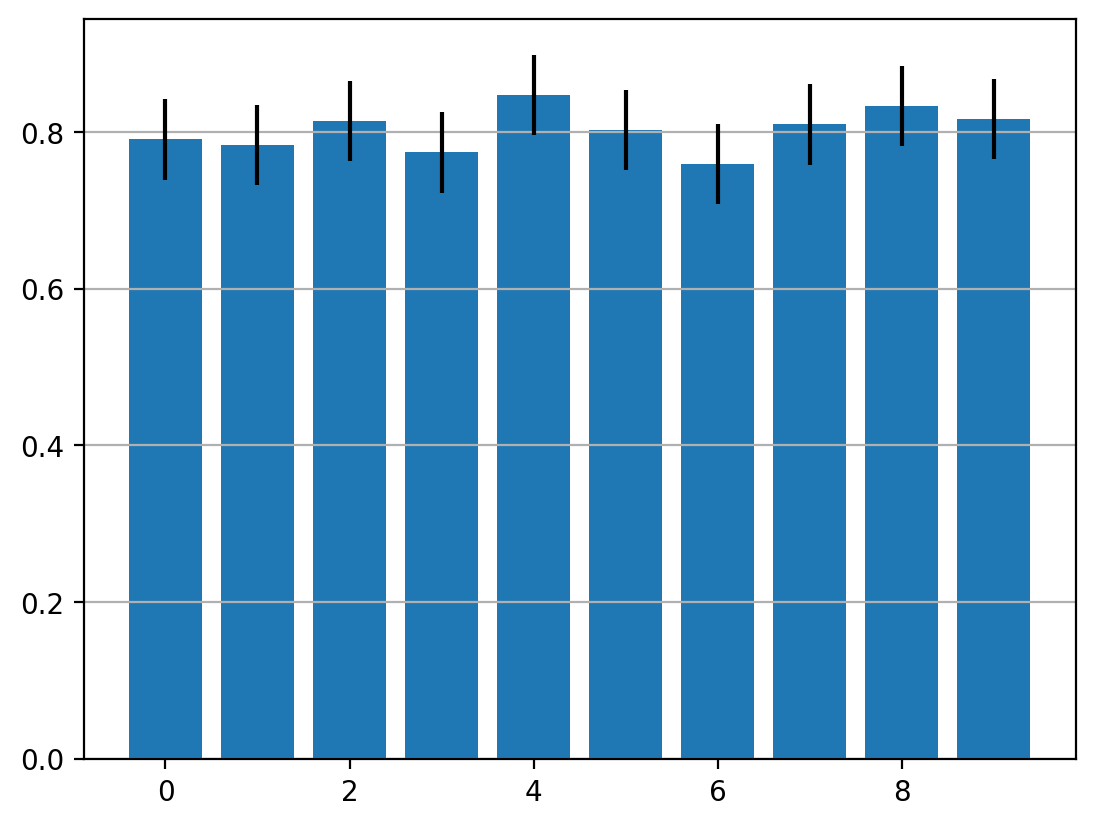

In [38]:
plt.bar(range(len(scores)), scores, yerr=2 * scores.std())
plt.grid(axis="y")
plt.show()

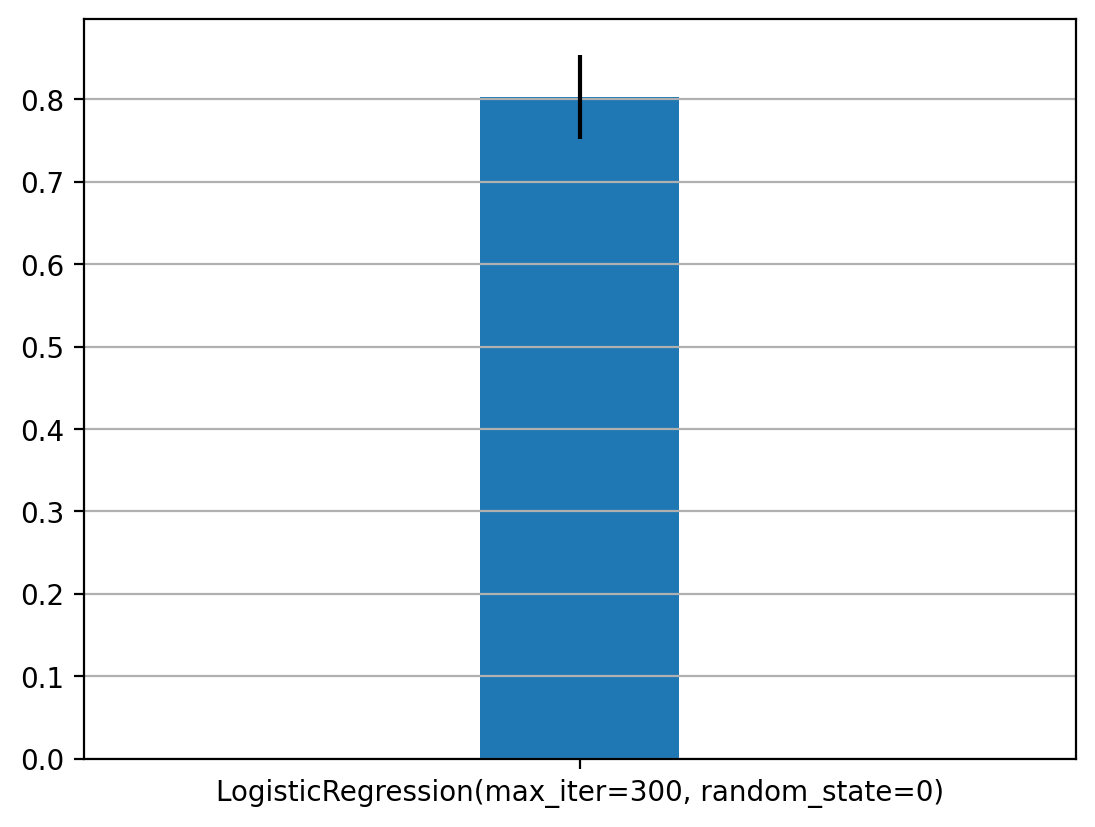

In [39]:
plt.bar([str(model)], scores.mean(), yerr=2 * scores.std())
plt.xlim(-2, 2)
plt.grid(axis="y")
plt.show()

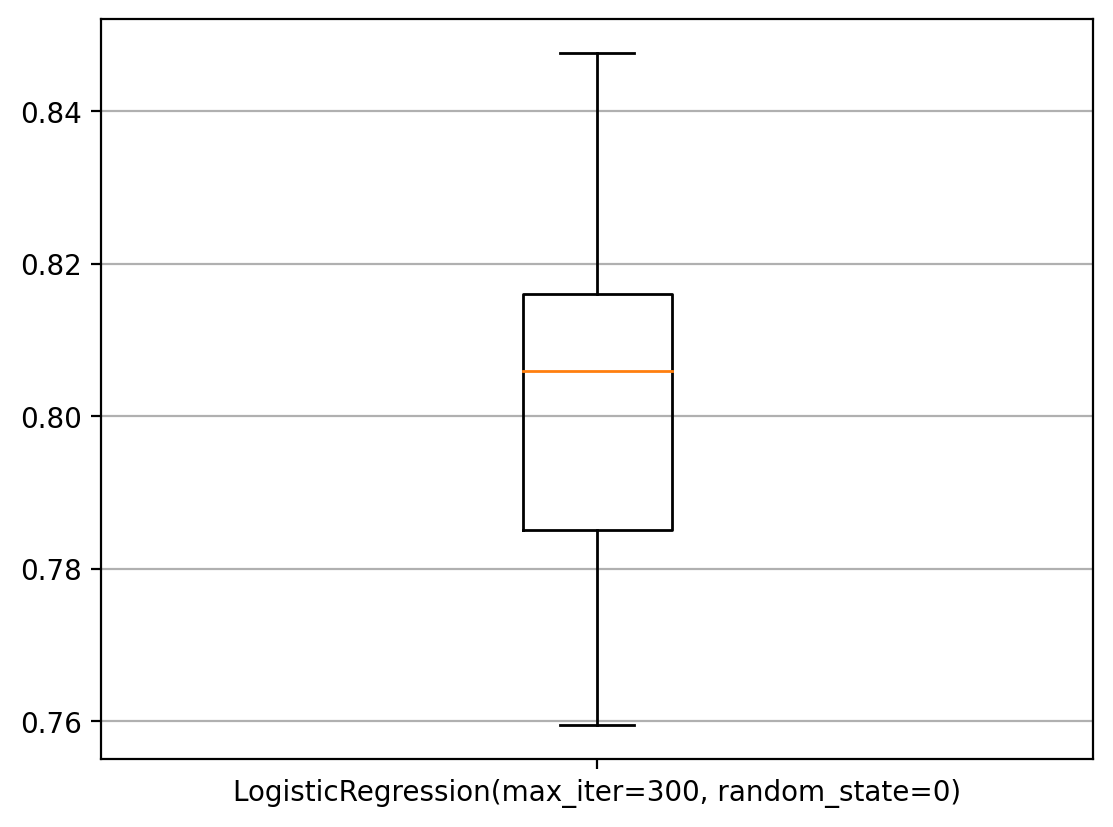

In [40]:
plt.boxplot(scores)
plt.xticks([1], [str(model)])
plt.grid(axis="y")
plt.show()

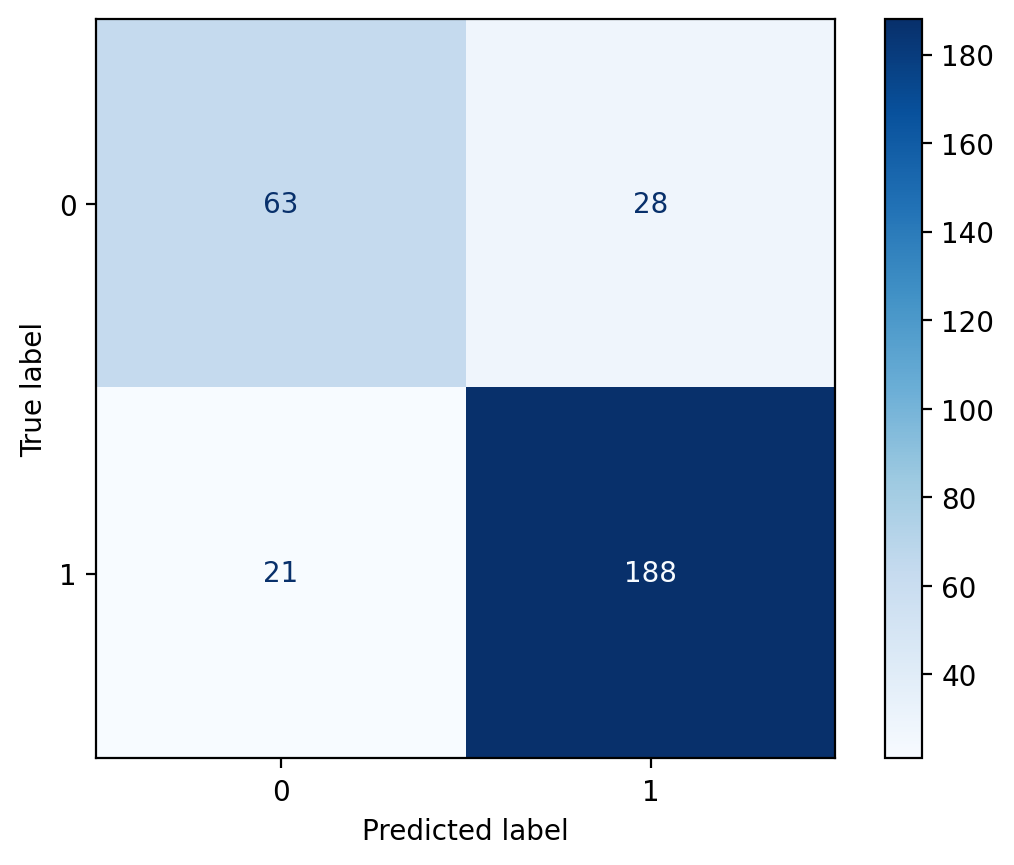

In [41]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    Y_test, y_pred, cmap=plt.cm.Blues
)

In [42]:
sklearn.metrics.roc_auc_score(Y_test, y_pred)

0.7959146117040854

### RandomForestClassifier

In [43]:
model = ensemble.RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_pca, Y_train)  # training

RandomForestClassifier(random_state=0)

In [44]:
y_pred = model.predict(X_test_pca)  # predictions
score = metrics.balanced_accuracy_score(Y_test, y_pred)  # scoring
print(f"Balanced accuracy score: {score:.3g}")

Balanced accuracy score: 0.763


###### Cross-Validation

In [45]:
pca_CV = decomposition.PCA(n_components=15)
model_CV = ensemble.RandomForestClassifier(n_estimators=100, random_state=0)

pipe = pipeline.Pipeline(steps=[('scaler', StandardScaler()), ("pca", pca_CV), ("model", model_CV)])

scores = model_selection.cross_val_score(pipe, X, y, cv=CV, scoring=SCORINGS)

with np.printoptions(precision=8):
    print(scores)

print(f"\n{SCORINGS}: {scores.mean():.8f}, with std dev: {scores.std():.2f}\n")

[0.79285714 0.69761905 0.78095238 0.77380952 0.84761905 0.77857143
 0.65       0.80952381 0.79047619 0.76190476]

balanced_accuracy: 0.76833333, with std dev: 0.05



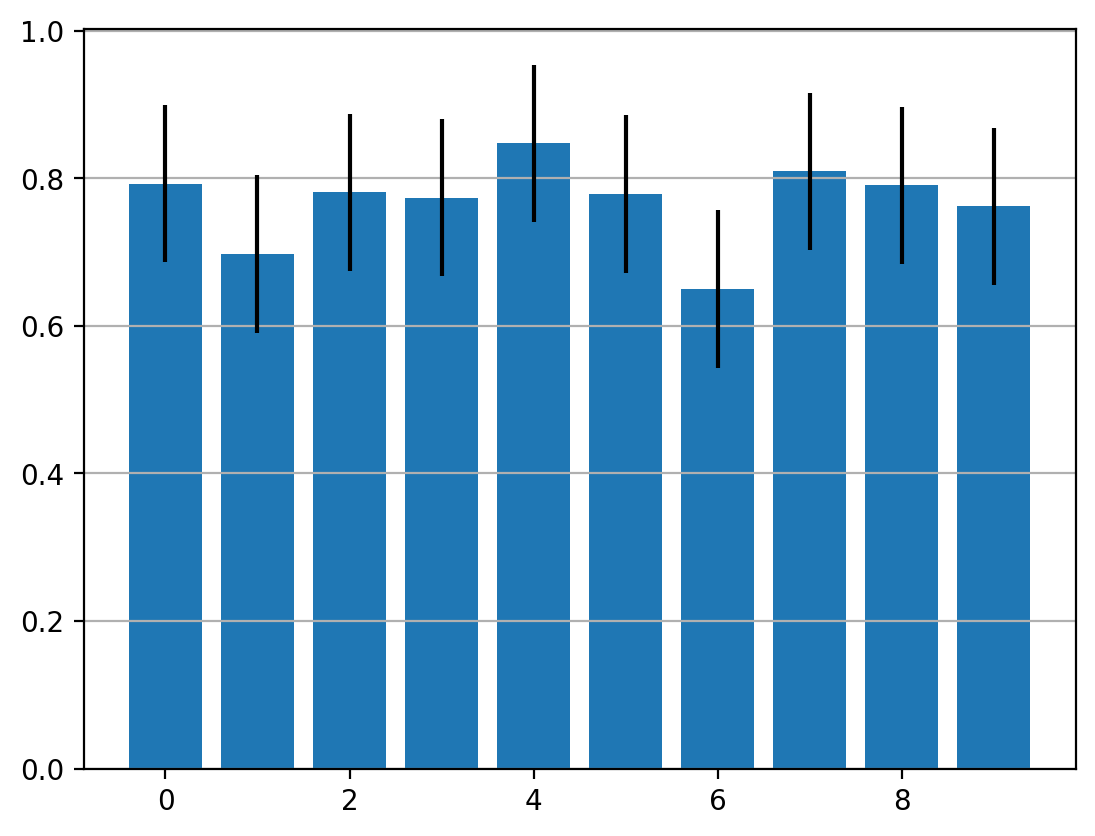

In [46]:
plt.bar(range(len(scores)), scores, yerr=2 * scores.std())
plt.grid(axis="y")
plt.show()

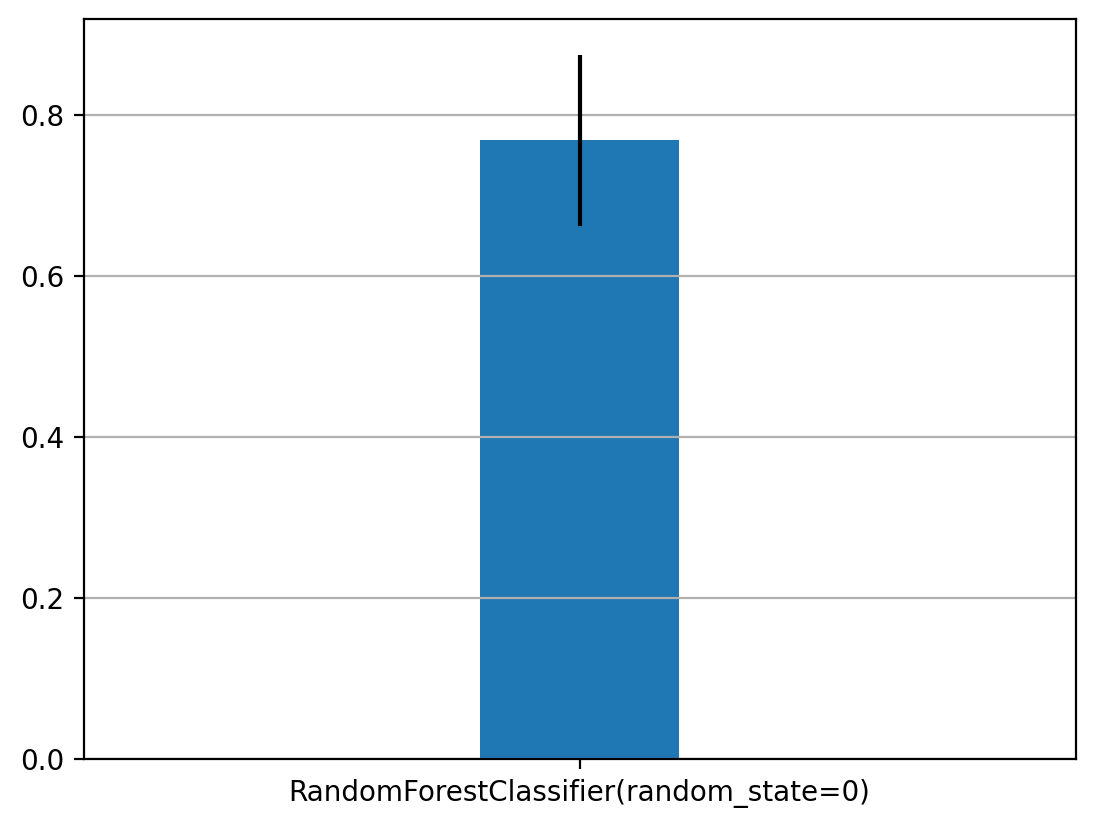

In [47]:
plt.bar([str(model)], scores.mean(), yerr=2 * scores.std())
plt.xlim(-2, 2)
plt.grid(axis="y")
plt.show()

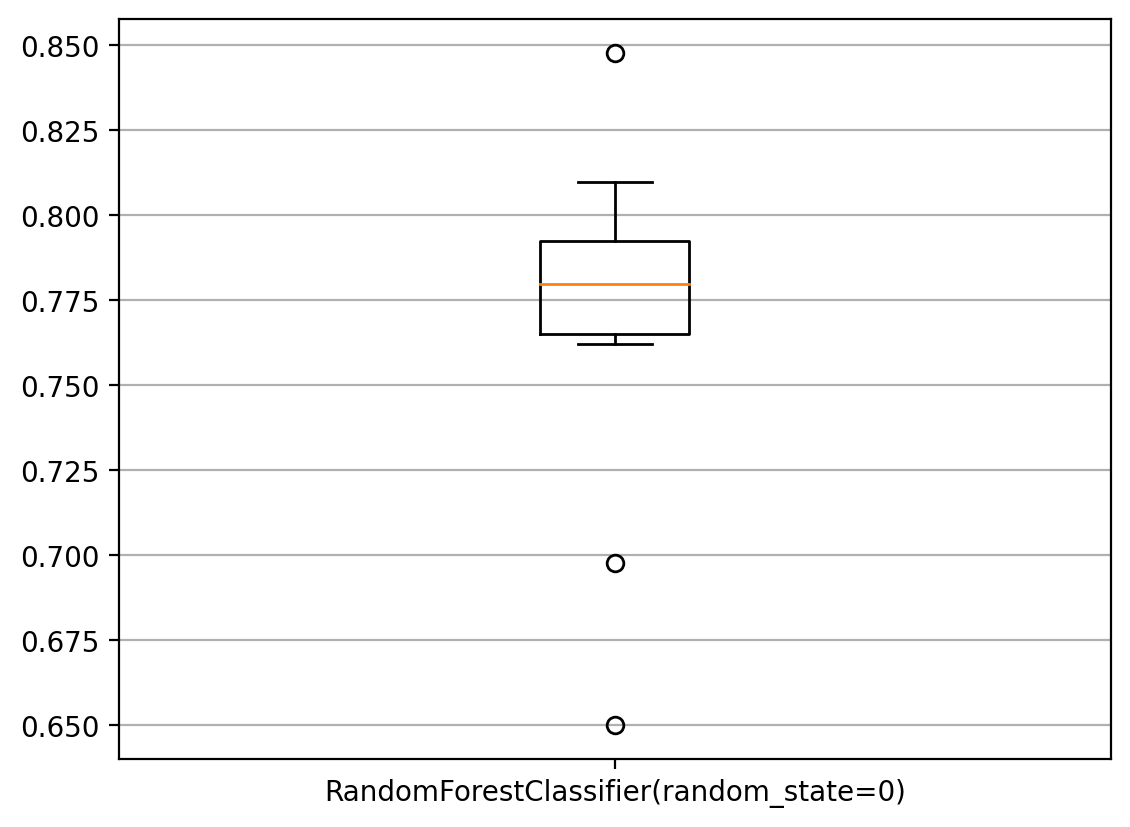

In [48]:
plt.boxplot(scores)
plt.xticks([1], [str(model)])
plt.grid(axis="y")
plt.show()

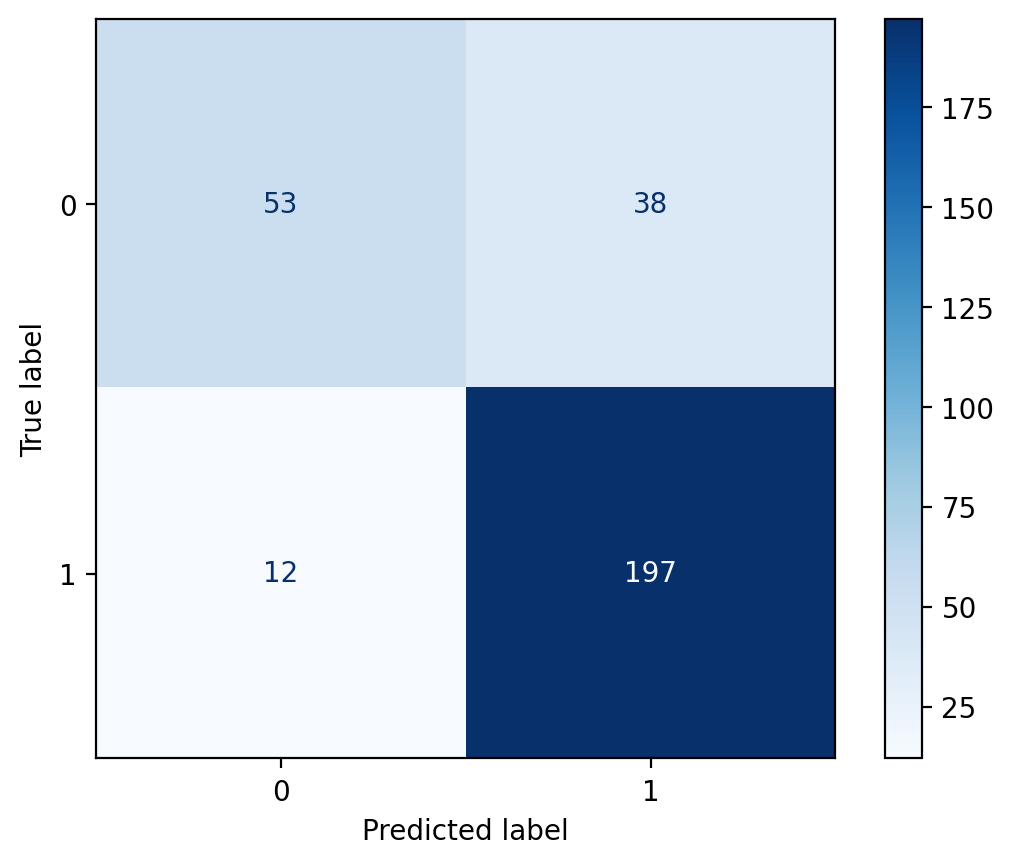

In [49]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    Y_test, y_pred, cmap=plt.cm.Blues
)

In [50]:
sklearn.metrics.roc_auc_score(Y_test, y_pred)

0.7625006572374993

### DecisionTreeClassifier

In [51]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train_pca, Y_train)  # training

DecisionTreeClassifier()

In [52]:
y_pred = model.predict(X_test_pca)  # predictions
score = metrics.balanced_accuracy_score(Y_test, y_pred)  # scoring
print(f"Balanced accuracy score: {score:.3g}")

Balanced accuracy score: 0.669


###### Cross-Validation

In [53]:
pca_CV = decomposition.PCA(n_components=15)
model_CV = DecisionTreeClassifier()

pipe = pipeline.Pipeline(steps=[('scaler', StandardScaler()), ("pca", pca_CV), ("model", model_CV)])

scores = model_selection.cross_val_score(pipe, X, y, cv=CV, scoring=SCORINGS)

with np.printoptions(precision=8):
    print(scores)

print(f"\n{SCORINGS}: {scores.mean():.8f}, with std dev: {scores.std():.2f}\n")

[0.78571429 0.67857143 0.73333333 0.6        0.83333333 0.69761905
 0.66428571 0.7452381  0.68333333 0.62857143]

balanced_accuracy: 0.70500000, with std dev: 0.07



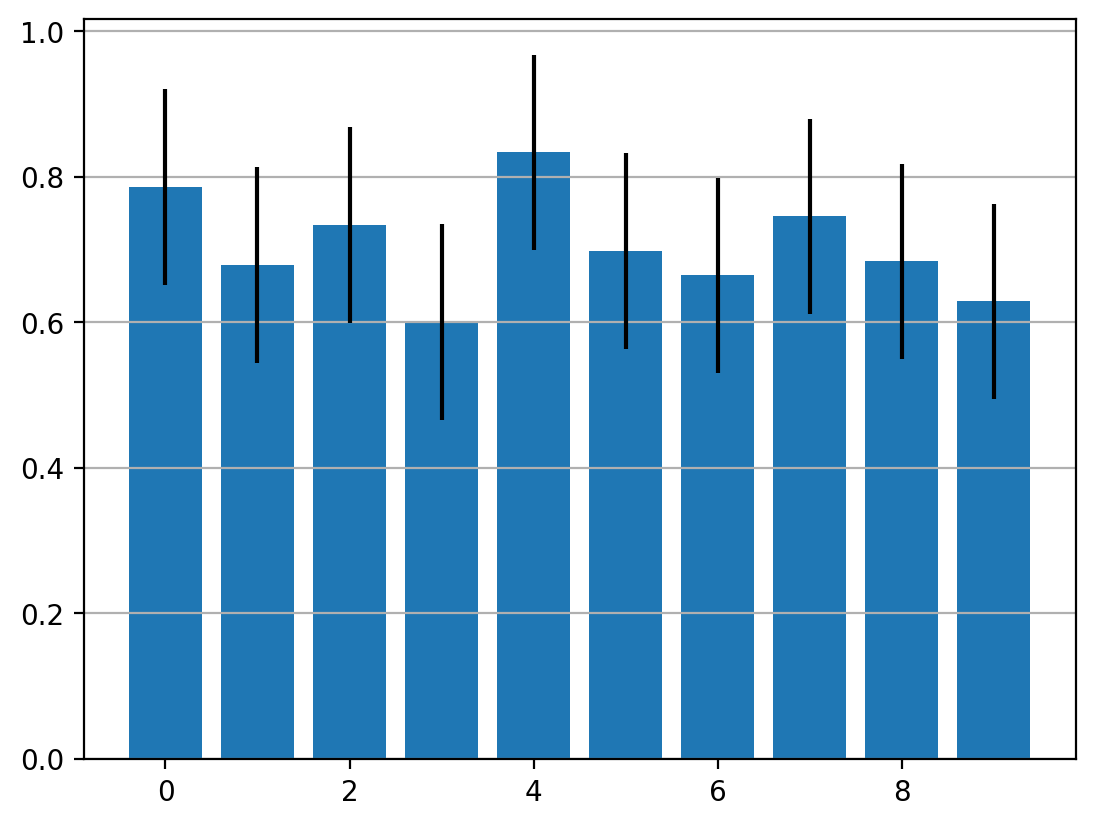

In [54]:
plt.bar(range(len(scores)), scores, yerr=2 * scores.std())
plt.grid(axis="y")
plt.show()

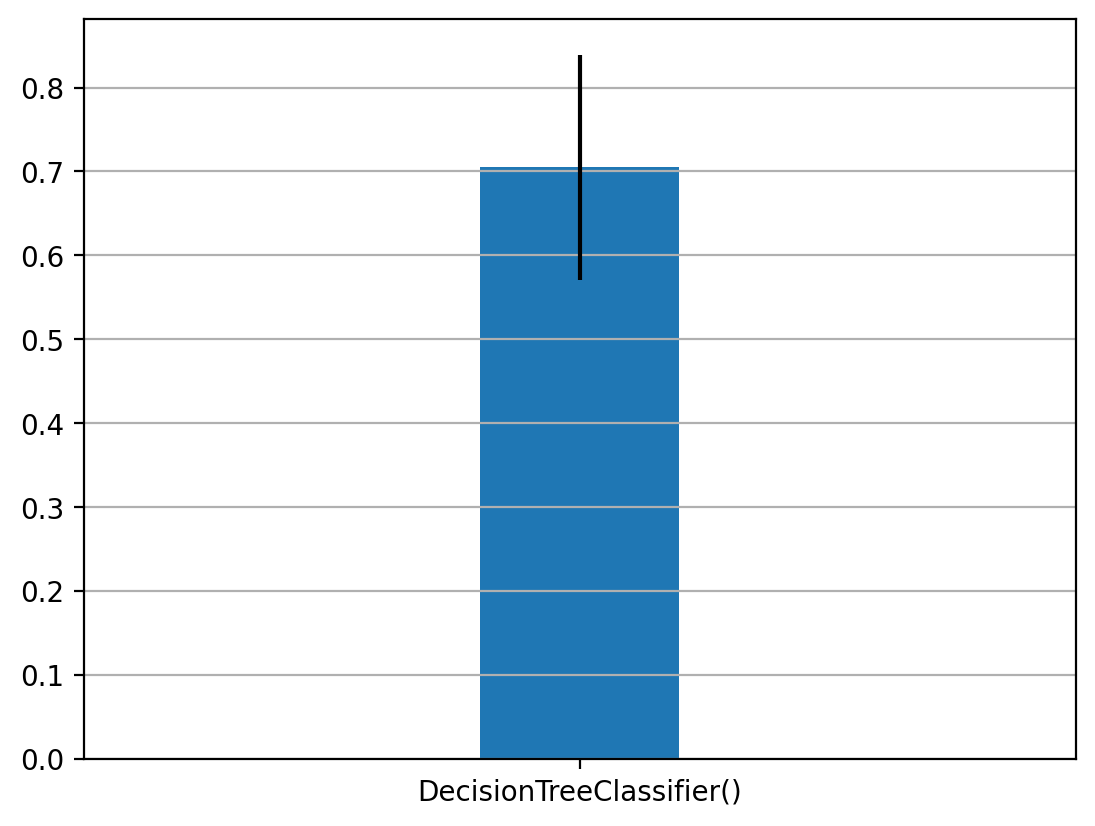

In [55]:
plt.bar([str(model)], scores.mean(), yerr=2 * scores.std())
plt.xlim(-2, 2)
plt.grid(axis="y")
plt.show()

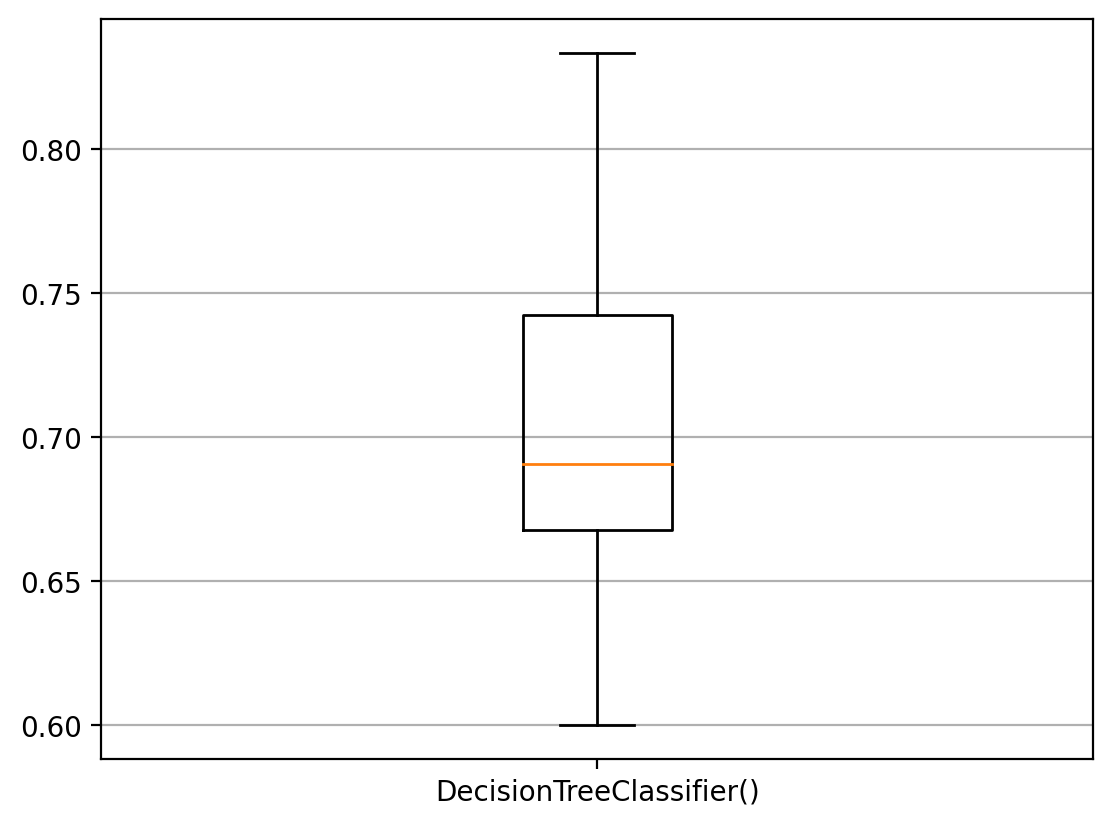

In [56]:
plt.boxplot(scores)
plt.xticks([1], [str(model)])
plt.grid(axis="y")
plt.show()

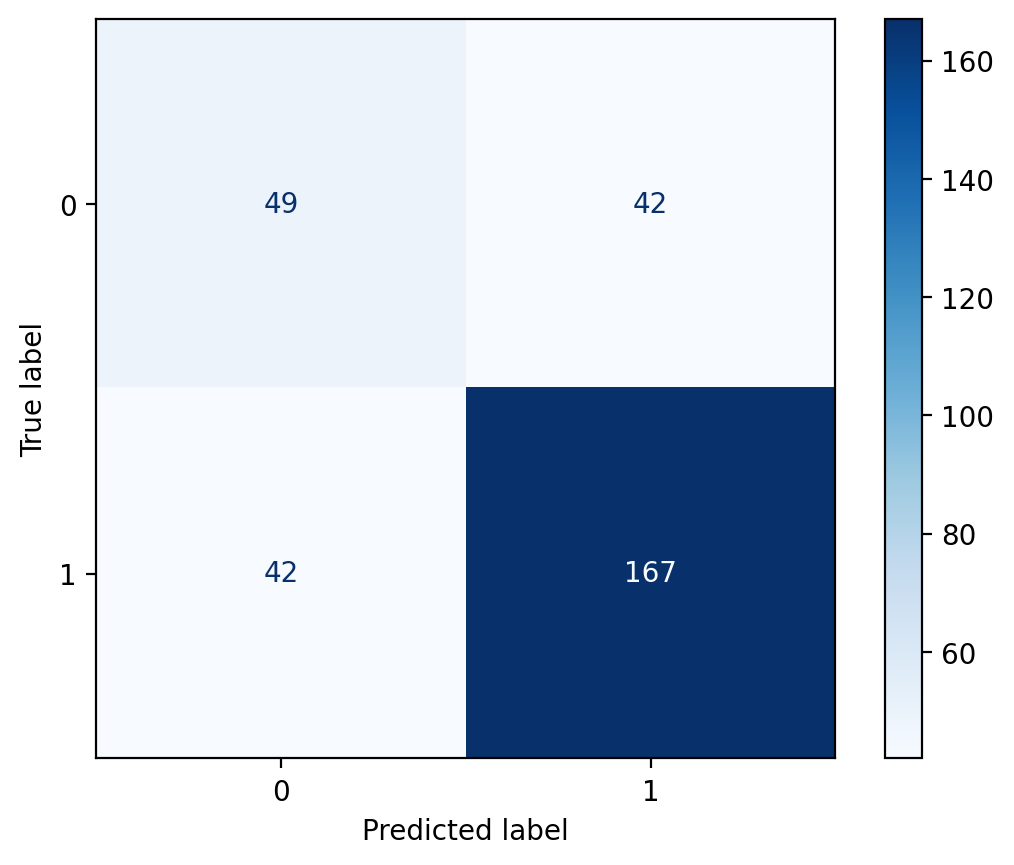

In [57]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    Y_test, y_pred, cmap=plt.cm.Blues
)

In [58]:
sklearn.metrics.roc_auc_score(Y_test, y_pred)

0.6687523003312477

## Sur/Sous-échantillonage:

### Under-Sampling :

In [59]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

In [60]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = model_selection.train_test_split(
    X_rus, y_rus, test_size=0.3
)

In [61]:
scaler = StandardScaler()
scaler.fit(X_train_rus)
X_train_scaled_rus = scaler.transform(X_train_rus)
X_test_scaled_rus = scaler.transform(X_test_rus)

In [62]:
pca = sklearn.decomposition.PCA(n_components = 15)
X_train_pca_rus = pca.fit_transform(X_train_scaled_rus)
X_test_pca_rus = pca.transform(X_test_scaled_rus)

Under-Sampling


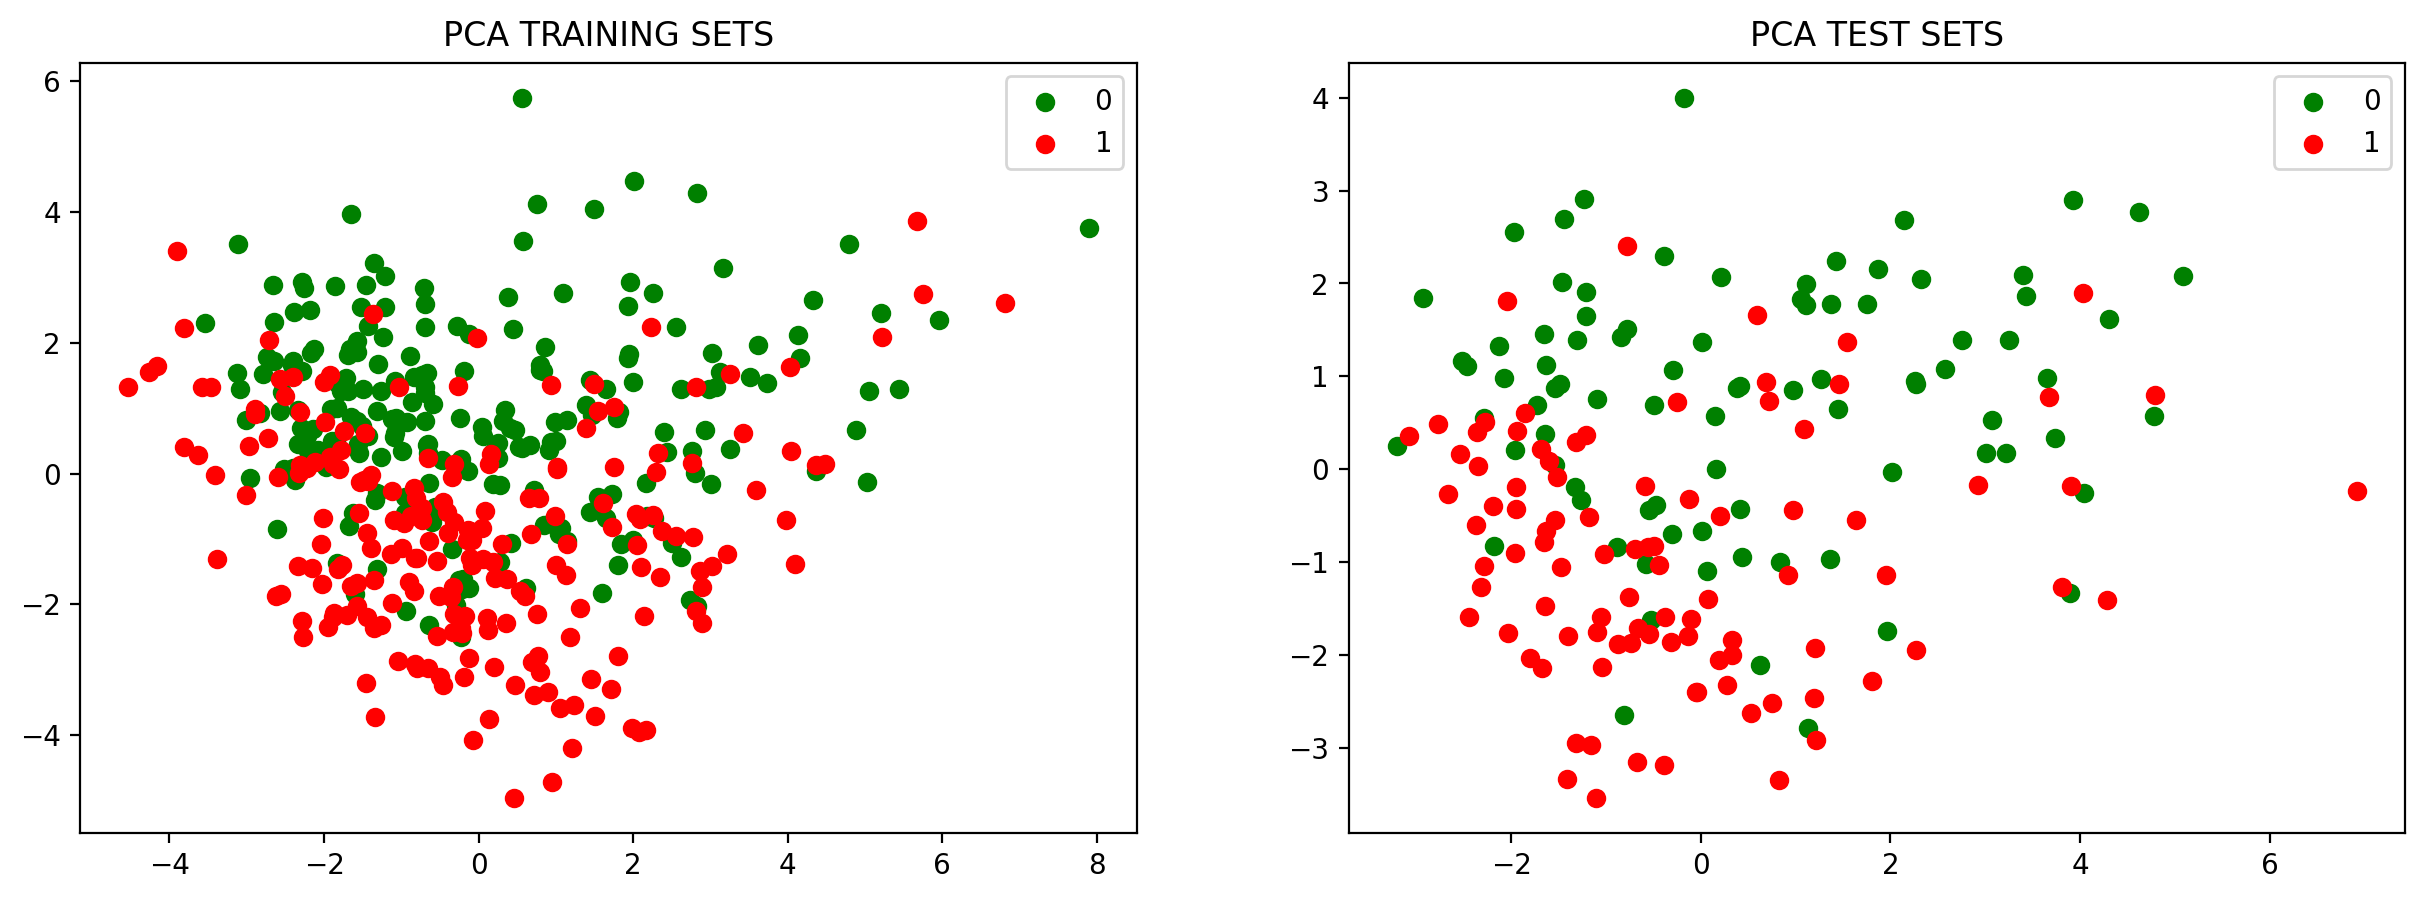

In [63]:
print("Under-Sampling")
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("PCA TRAINING SETS")
VisualizingDataset(X_train_pca_rus, y_train_rus)
plt.subplot(1,2,2)
plt.title("PCA TEST SETS")
VisualizingDataset(X_test_pca_rus, y_test_rus)
plt.show()

In [64]:
print("under-sampling")
unique, frequency = np.unique(y_train_rus, return_counts = True)
print("Unique Values:", unique) 
print("Frequency Values:", frequency)

under-sampling
Unique Values: [0 1]
Frequency Values: [214 206]


In [65]:
SCORINGS = "balanced_accuracy"

In [66]:
model = linear_model.LogisticRegression(random_state=0, max_iter = 300)
model.fit(X_train_pca_rus, y_train_rus)  # training

LogisticRegression(max_iter=300, random_state=0)

In [67]:
y_pred = model.predict(X_test_pca_rus)  # predictions
score = metrics.balanced_accuracy_score(y_test_rus, y_pred)  # scoring
print(f"Balanced accuracy score: {score:.3g}")
print (" ")
print(metrics.classification_report(y_test_rus, y_pred))

Balanced accuracy score: 0.85
 
              precision    recall  f1-score   support

           0       0.84      0.85      0.84        86
           1       0.86      0.85      0.86        94

    accuracy                           0.85       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.85      0.85      0.85       180



In [68]:
pca_CV = decomposition.PCA(n_components=15)
model_CV = linear_model.LogisticRegression(random_state=0, max_iter = 300)

pipe = pipeline.Pipeline(steps=[('scaler', StandardScaler()),("pca", pca_CV), ("model", model_CV)])

scores = model_selection.cross_val_score(pipe, X_rus, y_rus, cv=CV, scoring=SCORINGS)

with np.printoptions(precision=8):
    print(scores)

print(f"\n{SCORINGS}: {scores.mean():.8f}, with std dev: {scores.std():.2f}\n")

[0.81666667 0.76666667 0.81666667 0.81666667 0.81666667 0.83333333
 0.71666667 0.85       0.81666667 0.76666667]

balanced_accuracy: 0.80166667, with std dev: 0.04



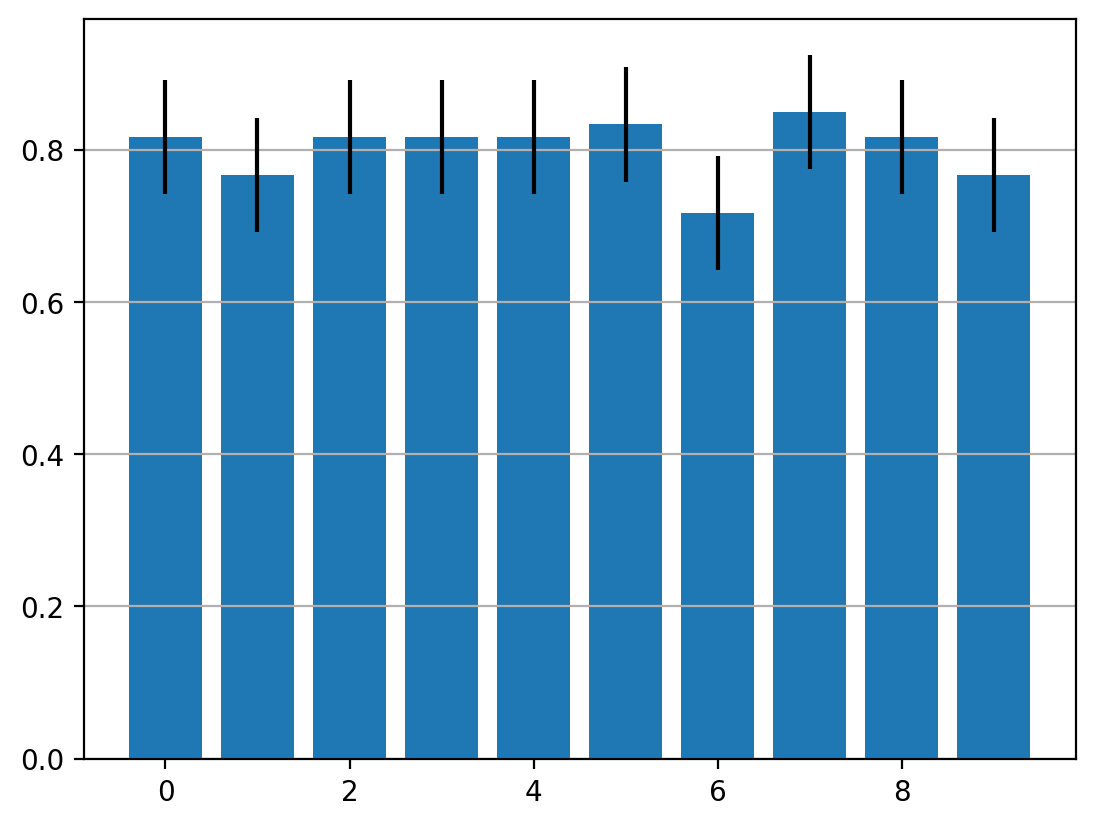

In [69]:
plt.bar(range(len(scores)), scores, yerr=2 * scores.std())
plt.grid(axis="y")
plt.show()

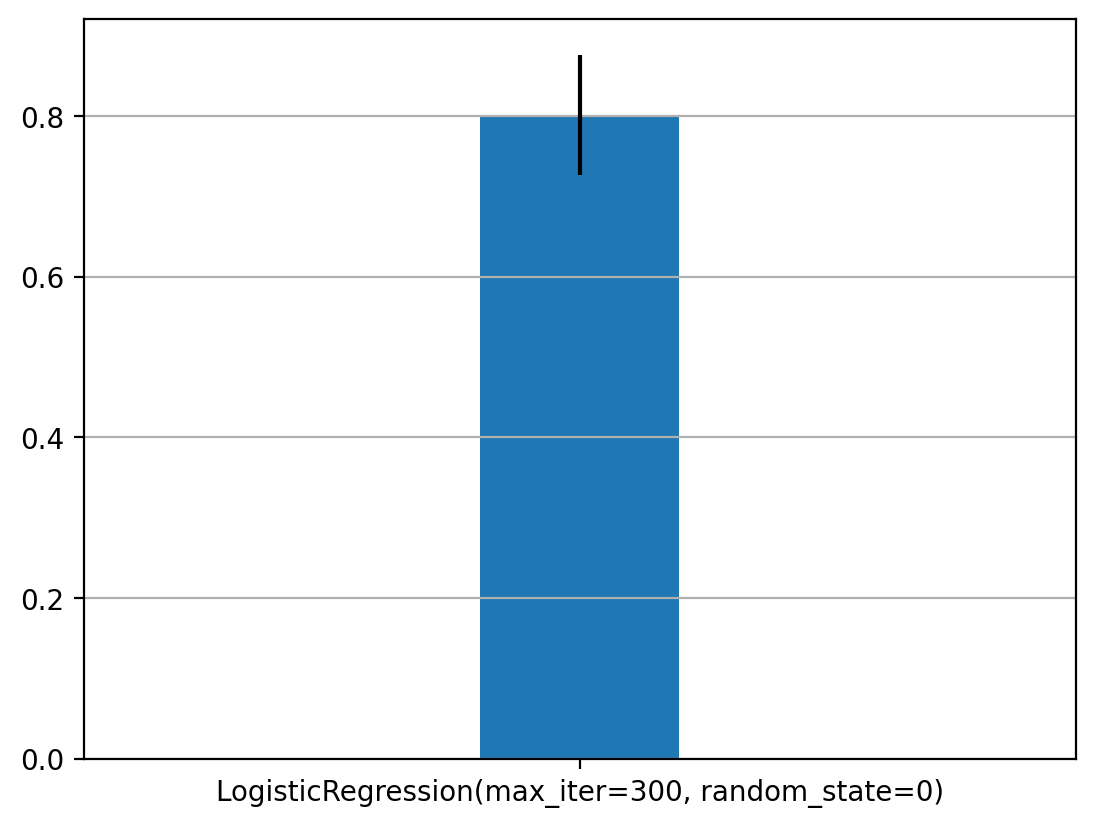

In [70]:
plt.bar([str(model)], scores.mean(), yerr=2 * scores.std())
plt.xlim(-2, 2)
plt.grid(axis="y")
plt.show()

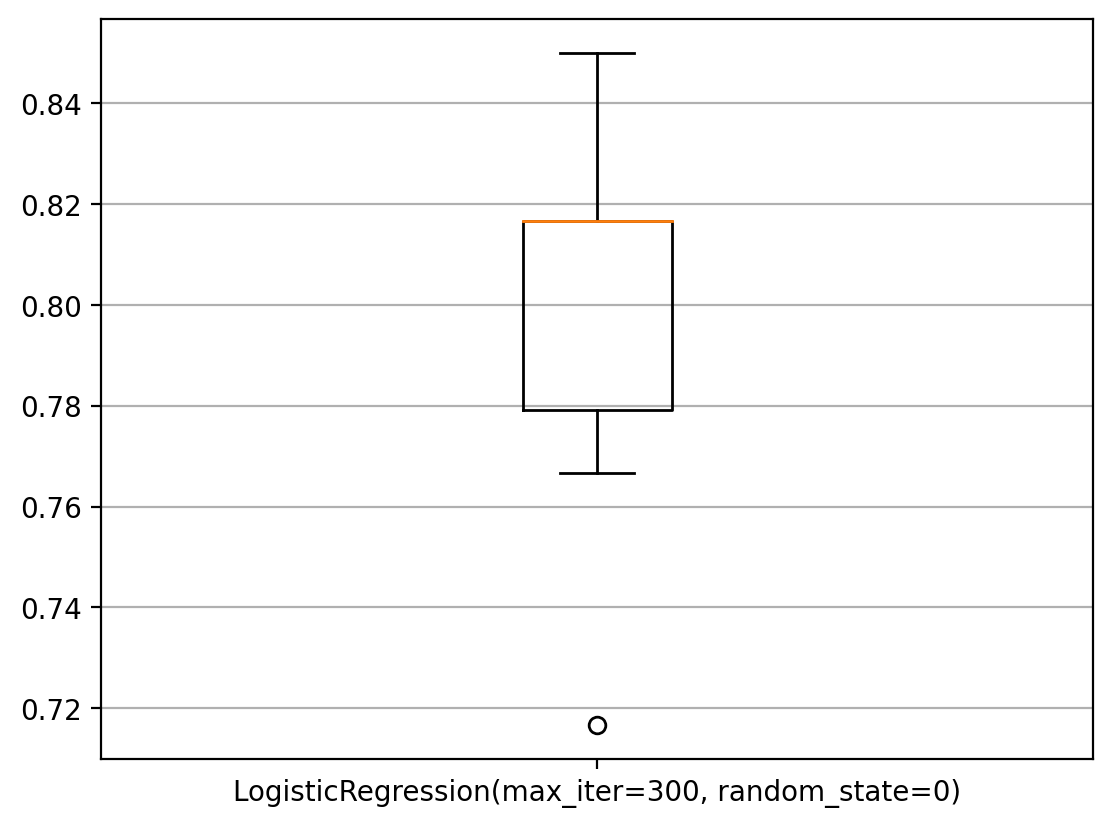

In [71]:
plt.boxplot(scores)
plt.xticks([1], [str(model)])
plt.grid(axis="y")
plt.show()

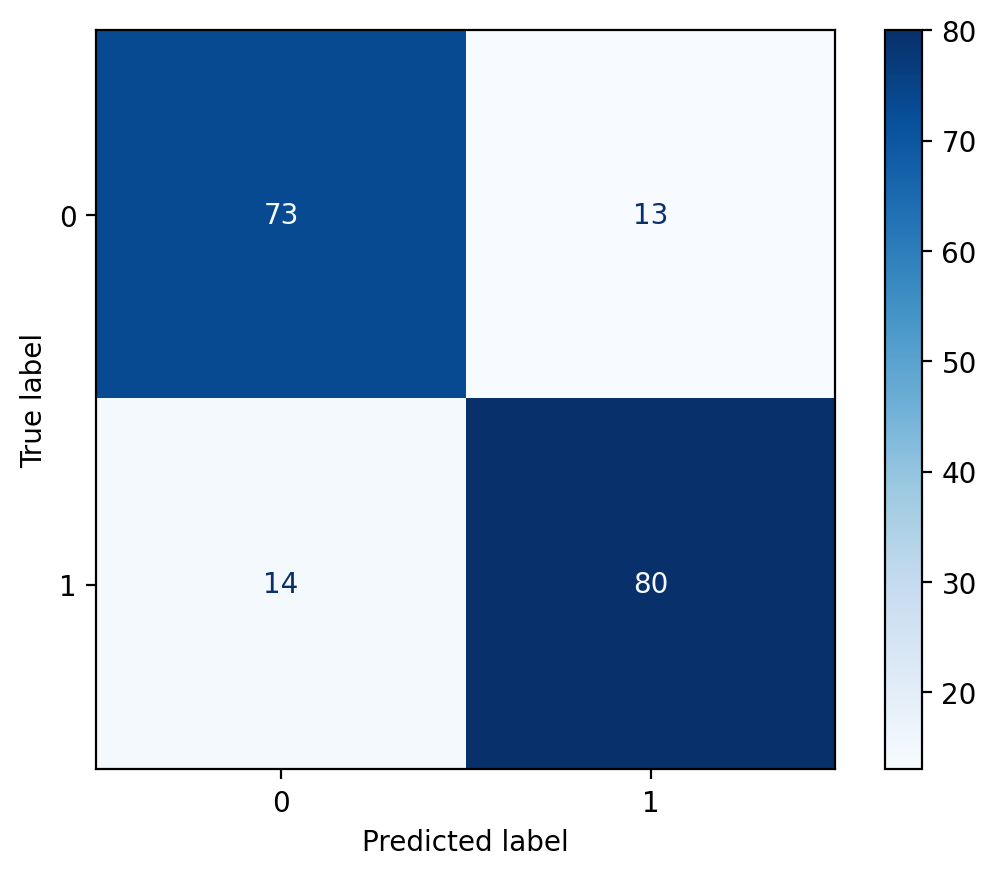

In [72]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test_rus, y_pred, cmap=plt.cm.Blues
)

In [73]:
sklearn.metrics.roc_auc_score(y_test_rus, y_pred)

0.8499505195447796

### Over-Sampling :

In [74]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

In [75]:
X_train_ros, X_test_ros, y_train_ros, y_test_ros = model_selection.train_test_split(
    X_ros, y_ros, test_size=0.3
)

In [76]:
X_train_scaled_ros = scaler.transform(X_train_ros)
X_test_scaled_ros = scaler.transform(X_test_ros)

In [77]:
pca = sklearn.decomposition.PCA(n_components = 15)
X_train_pca_ros = pca.fit_transform(X_train_scaled_ros)
X_test_pca_ros = pca.transform(X_test_scaled_ros)

Over-Sampling


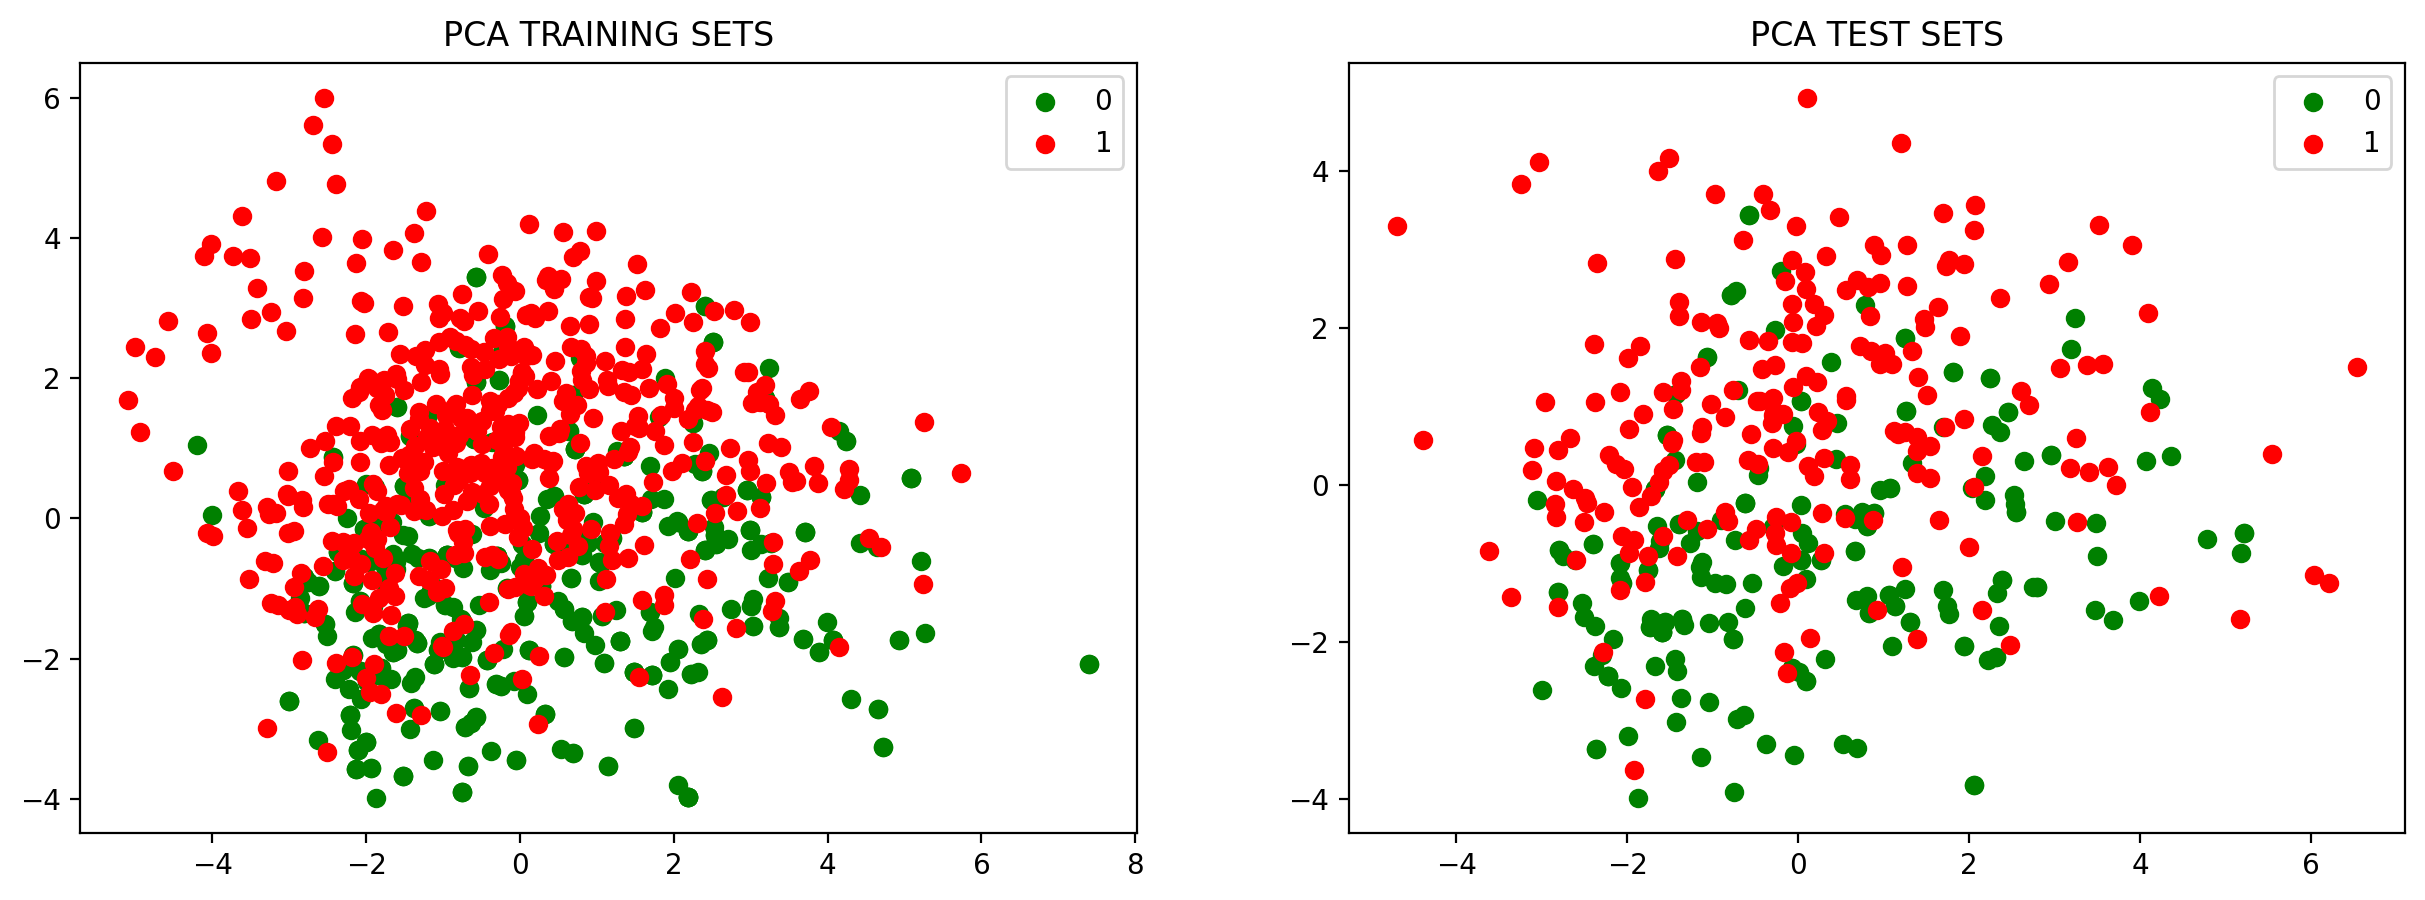

In [78]:
print("Over-Sampling")
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("PCA TRAINING SETS")
VisualizingDataset(X_train_pca_ros, y_train_ros)
plt.subplot(1,2,2)
plt.title("PCA TEST SETS")
VisualizingDataset(X_test_pca_ros, y_test_ros)
plt.show()

In [79]:
print("over-sampling")
unique2, frequency2 = np.unique(y_train_ros, return_counts = True)
print("Unique Values:", unique2) 
print("Frequency Values:", frequency2)

over-sampling
Unique Values: [0 1]
Frequency Values: [492 488]


In [80]:
SCORINGS = "balanced_accuracy"

In [81]:
model = linear_model.LogisticRegression(random_state=0, max_iter = 300)
model.fit(X_train_pca_ros, y_train_ros)  # training

LogisticRegression(max_iter=300, random_state=0)

In [82]:
y_pred = model.predict(X_test_pca_ros)  # predictions
score = metrics.balanced_accuracy_score(y_test_ros, y_pred)  # scoring
print(f"Balanced accuracy score: {score:.3g}")
print (" ")
print(metrics.classification_report(y_test_ros, y_pred))

Balanced accuracy score: 0.836
 
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       208
           1       0.84      0.83      0.84       212

    accuracy                           0.84       420
   macro avg       0.84      0.84      0.84       420
weighted avg       0.84      0.84      0.84       420



In [83]:
pca_CV = decomposition.PCA(n_components=15)
model_CV = linear_model.LogisticRegression(random_state=0, max_iter = 300)

pipe = pipeline.Pipeline(steps=[('scaler', StandardScaler()),("pca", pca_CV), ("model", model_CV)])

scores = model_selection.cross_val_score(pipe, X_ros, y_ros, cv=CV, scoring=SCORINGS)

with np.printoptions(precision=8):
    print(scores)

print(f"\n{SCORINGS}: {scores.mean():.8f}, with std dev: {scores.std():.2f}\n")

[0.82142857 0.8        0.86428571 0.82142857 0.80714286 0.88571429
 0.79285714 0.83571429 0.82857143 0.82142857]

balanced_accuracy: 0.82785714, with std dev: 0.03



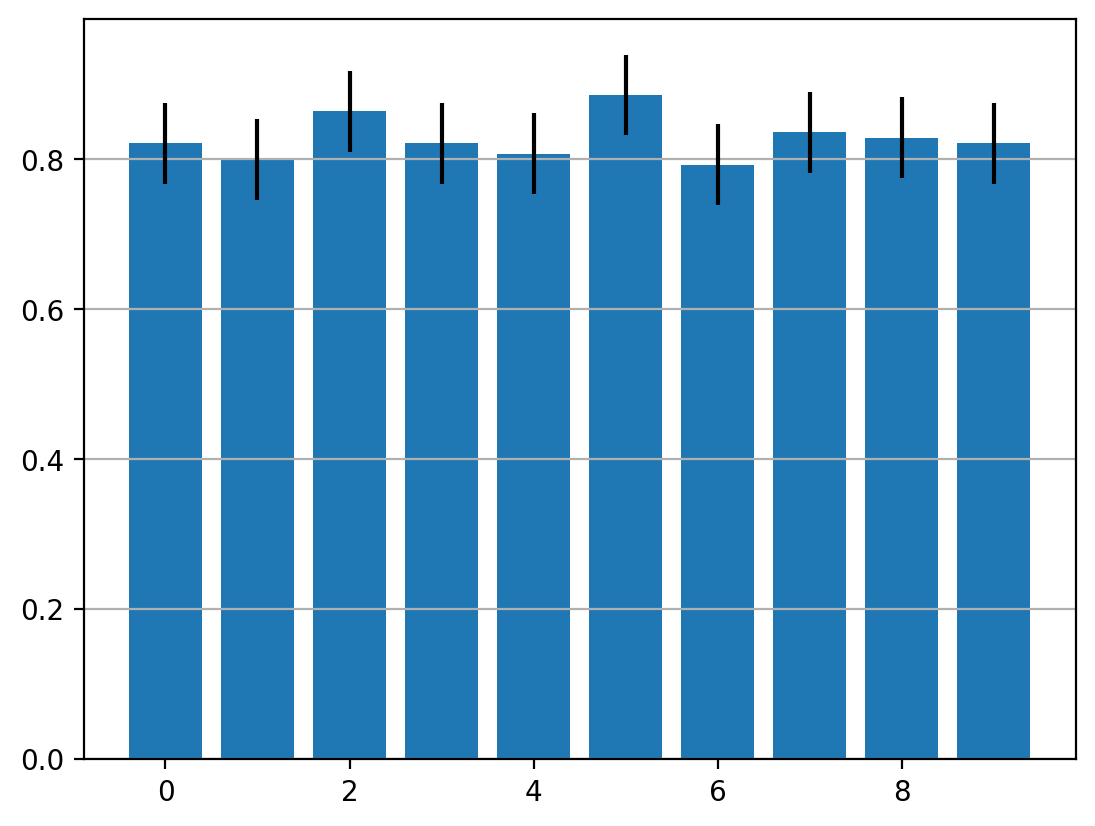

In [84]:
plt.bar(range(len(scores)), scores, yerr=2 * scores.std())
plt.grid(axis="y")
plt.show()

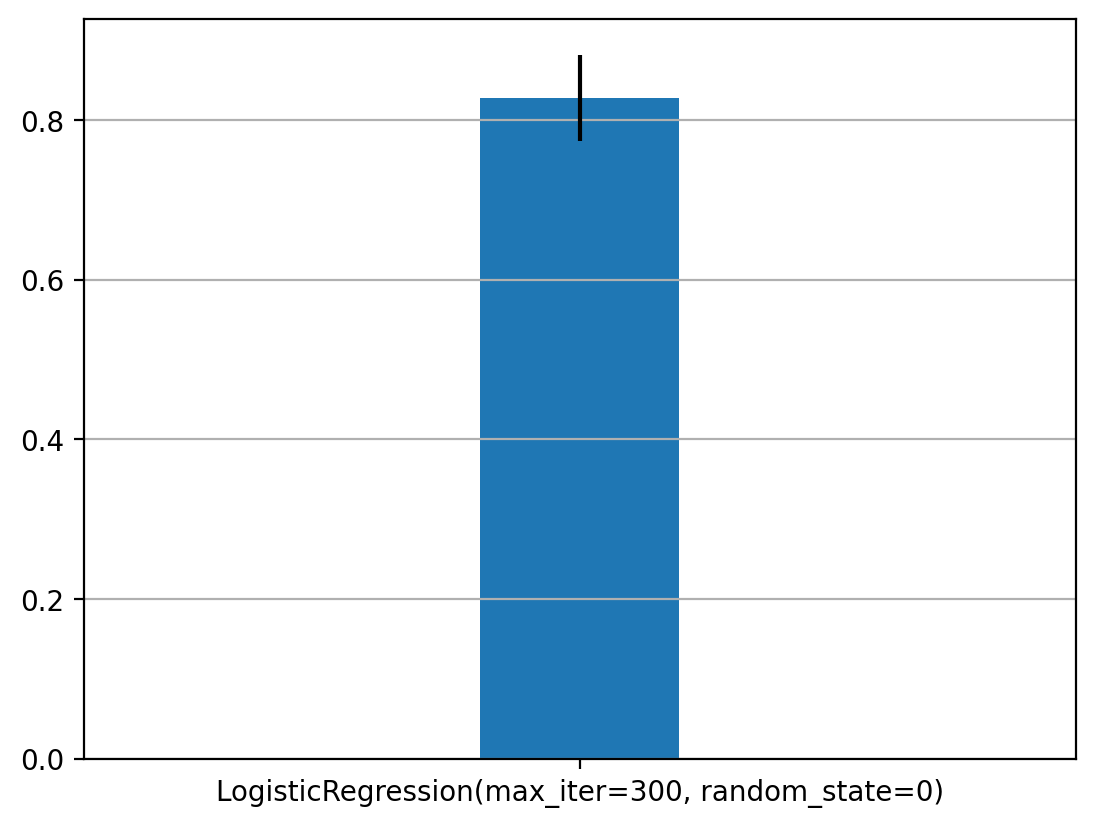

In [85]:
plt.bar([str(model)], scores.mean(), yerr=2 * scores.std())
plt.xlim(-2, 2)
plt.grid(axis="y")
plt.show()

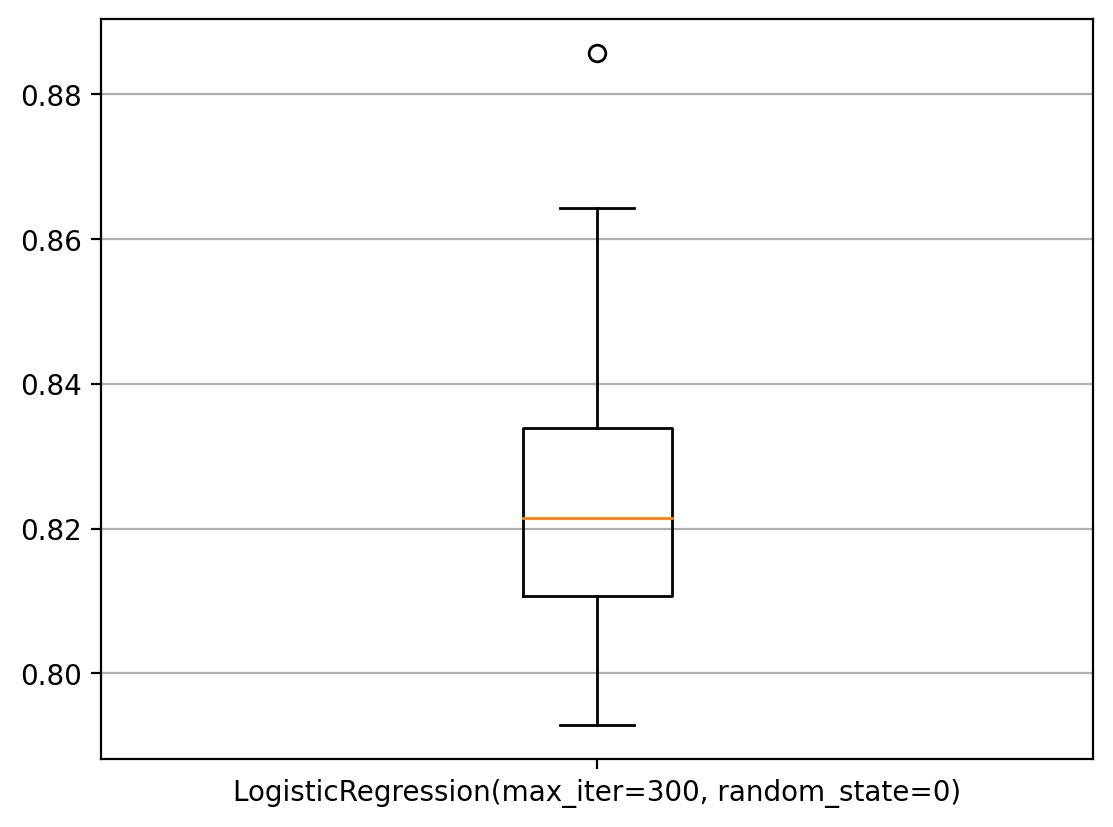

In [88]:
plt.boxplot(scores)
plt.xticks([1], [str(model)])
plt.grid(axis="y")
plt.show()

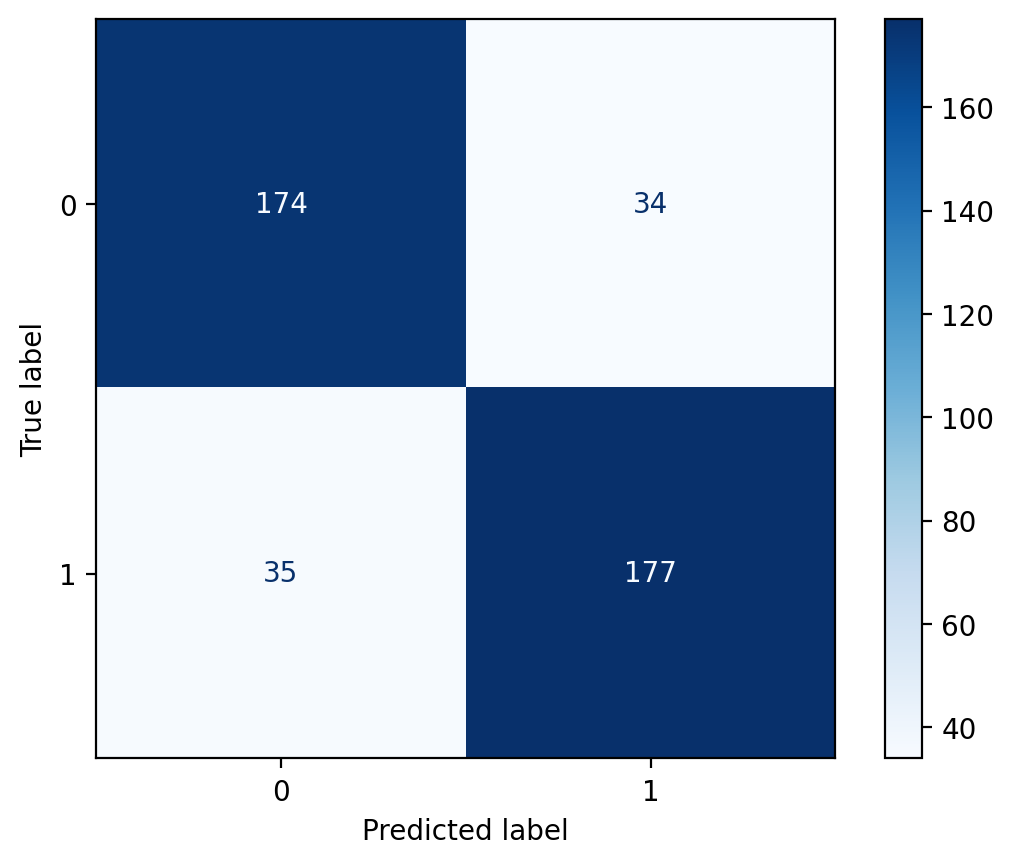

In [86]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test_ros, y_pred, cmap=plt.cm.Blues
)

In [87]:
sklearn.metrics.roc_auc_score(y_test_ros, y_pred)

0.8357220609579101